In [50]:
#Pre-process the Reviews /Users/khanfarabi/OneDrive - The University of Memphis/Explain_MLN/Explanation_yelp/
import random
import sys
import random
import re
from collections import defaultdict

ifile1 = open("full-meta-data.txt")
revid = 0
users = defaultdict(list)
for ln in ifile1:
    parts = ln.strip().split("\t")
    users[parts[0]].append(revid)
    revid = revid + 1
ifile1.close()
#print(users)


H11=defaultdict(list)
#sys.exit()
userids = []
#print(users)
c =0
#Select reviewer subset based on tunable parameters (max-reviews and min-reviews limit,sampling ratio)
minreviews =10
maxreviews =25
samplingratio =0.1
for u in users:
    if len(users[u])>minreviews and len(users[u])<maxreviews:        
        if random.random() < samplingratio:
            userids.append(u)
            c= c + len(users[u])




ifile = open("reviewContent.txt",encoding='ISO-8859-1')
ifile1 = open("full-meta-data.txt")
s_words = []
sfile = open("Words.txt")
for ln in sfile:
    s_words.append(ln.strip())
sfile.close()
stopwords = []
sfile = open("stopwords.txt")
for ln in sfile:
    stopwords.append(ln.strip())
sfile.close()

flags = (re.UNICODE if sys.version < '3' and type(text) is unicode
         else 0)
ofile = open("all_revs1.txt",'w')
ofile1 = open("metadata.txt",'w')
cnt = 0
revid = 0
qrat={}
windex = defaultdict(list)
#Tunable parameter to keep non-sentiment words
PNonSentWords = 0.30
WORDS={}
w_per_ht=defaultdict(list)
w_per_user=defaultdict(list)
Rev_text_map={}
for ln in ifile:
    ln1 = ifile1.readline()
    parts1 = ln1.strip().split("\t")
    #print(parts1)
    if parts1[0] not in userids:
        continue
    #if cnt >= 10000:
    #    break
    keep = []
    parts = ln.strip().split("\t")
    for word in re.findall(r"\w[\w']*", parts[3], flags=flags):
        if word.isdigit() or len(word)==1:
            continue
        word_lower = word.lower()
        if word_lower in stopwords:
            continue
       # if word_lower in s_words:
            #keep.append(word_lower)
        elif random.random() < PNonSentWords:
            if not any(c.isdigit() for c in word_lower) and "'" not in word_lower:
                keep.append(word_lower)
    if float(parts1[2])<=2:
        cl = 0
    elif float(parts1[2])==3:
        cl = 1
    elif float(parts1[2])>=4:
        cl = 2
    if len(keep)>=10:
        cnt = cnt + 1
        ofile.write(" ".join(keep)+"\t"+str(cl)+"\n")
        WORDS[revid]=keep
        
        qrat[revid]=cl
        Rev_text_map[revid]=parts[3]
        H11[parts1[1]].append(revid)
        ofile1.write(ln1)
        for w in keep:
            windex[w].append(revid)
            w_per_ht[w].append(parts1[1])
            w_per_user[w].append(parts1[0])
        revid = revid + 1
ofile.close()
ofile1.close()
ifile.close()
ifile1.close()

#Tunable parameter (keep words only if repeated in > NumReps reviews)
NumReps = 10

#Filter review words
ifile = open("all_revs1.txt",encoding="ISO-8859-1")
ofile = open("processed_revs_1.txt",'w')
for ln in ifile:
    parts = ln.strip().split("\t")
    keep = []
    for w in parts[0].split(" "):
        if len(windex[w])>NumReps:
            keep.append(w)
    ofile.write(" ".join(keep)+"\t"+parts[1]+"\n")
ofile.close()
ifile.close()
print("Total Reviews="+str(len(WORDS)))

Total Reviews=5642


In [51]:
#Balancing The Data
WORDS1={}
t1=[]
t2=[]
t3=[]
c1=0
c2=0
c3=0
for y in WORDS:
    if qrat[y]==0:
        #if c3<15:
            t1.append(y)
            WORDS1[y]=WORDS[y]
            #c3=c3+1
    elif qrat[y]==1:
        if c1<515:
            t2.append(y)
            WORDS1[y]=WORDS[y]
            c1=c1+1
    elif qrat[y]==2:
        if c2<515:
            t3.append(y)
            WORDS1[y]=WORDS[y]
            c2=c2+1
print(len(t1),len(t2),len(t3),len(WORDS1))
        

514 515 515 1544


In [52]:
#train and target data
w11=[]
trg=[]
w12=[]
trg1=[]
for tt in WORDS1:
    s=' '
    #if qrat[tt]!=1:
    for kk in WORDS1[tt]:
       # if qrat[tt]!=1:
            w11.append(kk)
            s=str(kk)+s+"\t"
            #print(kk)
            trg.append(float(qrat[tt]))
        #w12.append(s)
        #trg1.append(qrat[tt])



In [53]:
#SVM Learner and generate feature weights
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
#from sklearn import cross_validation
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (precision_score,recall_score,f1_score)
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
from sklearn import svm
#from sklearn import cross_validation
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (precision_score,recall_score,f1_score)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OutputCodeClassifier

#OutputCodeClassifier(LinearSVC(random_state=0),code_size=2, random_state=0)

#Learn SVM Model
#ifile = open("processed_revs_1.txt",encoding="ISO-8859-1")
Y = trg
words =w11
unique_words = []

ss=set(words)
for w1 in ss:
        if w1 not in unique_words:
            unique_words.append(w1)

#######
#tf_transformer = TfidfVectorizer()
#f = tf_transformer.fit_transform(words)
#features = [((i, j), f[i,j]) for i, j in zip(*f.nonzero())]
#unique_word_ids = []
#for w in unique_words:
   # i = tf_transformer.vocabulary_.get(w)
    #unique_word_ids.append(i)

#clf =OneVsRestClassifier(SVC(kernel='linear'))#svm.LinearSVC(C=1)
#clf.fit(f,Y)
#p = clf.predict(f)
#print(f1_score(Y,p,average='weighted'))




#########
tf_transformer = TfidfVectorizer()
f = tf_transformer.fit_transform(words)
features = [((i, j), f[i,j]) for i, j in zip(*f.nonzero())]
unique_word_ids = []
for w in unique_words:
    i = tf_transformer.vocabulary_.get(w)
    unique_word_ids.append(i)

#clf =svm.LinearSVC(C=100,probability=True)
clf=svm.SVC(C=1.0, kernel='linear', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=True, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=- 1, decision_function_shape='ovr', random_state=None)
#svm.SVC(C=1.0, kernel='linear', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=True, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=- 1, decision_function_shape='ovr', random_state=None)

#OneVsRestClassifier(LinearSVC(random_state=0)) #svm.LinearSVC(C=1)
clf.fit(f,Y)
#clf.fit(f,Y)
p = clf.predict(f)
print(f1_score(Y,p,average='micro'))
from sklearn.metrics import accuracy_score
print(accuracy_score(Y,p))

#Store learned weights

#Tunable parameter, normalization range of weights
rangelower=0
rangehigher=1

C = clf.coef_
scaler = MinMaxScaler(feature_range=(rangelower,rangehigher))
vals = []
for i, j in zip(*C.nonzero()):
    vals.append([C[i,j]])
scaler.fit(vals)
V1 = scaler.transform(vals)
rows,cols = C.nonzero()
r_wts =  defaultdict(list)
ix= 0
for w in unique_words:
    r_wts[w] = [0,0,0]  
for i, j in zip(*C.nonzero()):
    #print(i,j)
    for k in tf_transformer.vocabulary_.keys():
        if tf_transformer.vocabulary_[k]==j:
            if k not in r_wts:
                break
            else:
                #if float(V1[ix][0])>0:
                r_wts[k][i] = V1[ix][0]
                break
    ix = ix + 1


#print(r_wts)

0.5354729314624137
0.5354729314624137


In [54]:
# Samehote Relation
H1={}
fl=open("samehote.txt","w")
for tt in H11:
    gh=[]
    for kk in H11[tt]:
        if kk in WORDS1:
            if kk not in gh:
                gh.append(kk)
    if len(gh)>1:
        H1[tt]=gh
        ggg=str(tt)+"::"+str(gh)
        fl.write(str(ggg)+"\n")
fl.close()       
for t in H1:
    pass#print(t,H1[t])   
print(len(H1))

267


In [55]:
#Sentance generation Word Embedding
sent=[]
sent1=[]
sent_map=defaultdict(list)
for ty in WORDS1:
    gh=[]
    gh.append(str(ty))
    #gh1=[]
    #gh2=[]
    for j in WORDS1[ty]:
        
        j1=str(j)
        #gh.append(str(ty))
        if j1 not in gh:
            gh.append(j1)
        #print(gh)
        
        
    if gh not in sent:
            sent.append(gh)
            
        
documents=[]
#documents1=[]
for t in sent:
    for jh in t:
             documents.append(jh)
        

In [56]:
#K-Means Run 14 

#cluster generation with k-means
import sys
from nltk.cluster import KMeansClusterer
import nltk
from sklearn import cluster
from sklearn import metrics
import gensim 
import operator
from gensim.models import Word2Vec


model = Word2Vec(sent, min_count=1)

X = model[model.wv.vocab]



NUM_CLUSTERS=10
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance,repeats=25)
assigned_clusters1 = kclusterer.cluster(X,assign_clusters=True)
#print (assigned_clusters)
cluster={}
words = list(model.wv.vocab)
for i, word in enumerate(words):
  gh=[] 
  gh1=[] 
  gh2=[] 
  if word.isdigit(): 
    cluster[word]=assigned_clusters1[i]
    #print (word + ":" + str(assigned_clusters[i]))
cluster_final={}
for j in range(NUM_CLUSTERS):
    gg=[]
    for tt in cluster:
        if int(cluster[tt])==int(j):
            if tt not in gg:
                gg.append(tt)
    if len(gg)>0:
                cluster_final[j]=gg
cc=0
final_clu={}
for t in cluster_final:
    ghh=[]
    for k in cluster_final[t]:
        if int(k) in WORDS:
               ghh.append(int(k))
    if len(ghh)>=2:
            final_clu[cc]=ghh
            cc=cc+1
s=0
for k in final_clu:
      s=s+len(final_clu[k])
print(s)       

<ipython-input-56-29ea8c2bad31>:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  X = model[model.wv.vocab]


1544


In [57]:
# Word annotated explsanation per query
ann1={}
c=0
for k in WORDS1:
    if qrat[k]==2:
        c=c+1
        c2=0
        gff=[]
        for gg in WORDS[k]:
            if gg in s_words:
                if c2<20:
                         gff.append(gg)
                         c2=c2+1
        if len(gff)>0:
           # if k in WORDSt:
                ann1[k]=gff
    
    elif qrat[k]==0:
        c=c+1
        c3=0
        gff1=[]
        for gg in WORDS1[k]:
            if gg in s_words:
                if c3<20:
                        gff1.append(gg)
                        c3=c3+1
                        
        if len(gff1)>0:
            #if k WORDSt:
                ann1[k]=gff1

ann={}
for t in ann1:
    if t in WORDS1:
        ann[t]=ann1[t]
print(len(ann))


982


In [58]:
gg=open("Review_Word_annotation.txt","w")
for t in ann:
    vv=str(t)+":"+str(ann[t])
    gg.write(str(vv)+"\n")
    print(t,ann[t])
gg.close()

0 ['great', 'excellent']
2 ['love', 'randomly', 'authentic', 'well', 'delicious', 'sweet', 'miss', 'excessive', 'shocked', 'delicious']
4 ['great', 'recommend', 'great', 'lost', 'noise']
6 ['enough', 'well', 'incredibly', 'upscale', 'outstanding']
7 ['nice', 'good', 'great', 'friendly']
8 ['bust', 'unjust', 'support', 'support', 'support']
9 ['great']
12 ['hot']
13 ['wasted', 'unfortunately', 'freaks', 'better']
15 ['drunk', 'worries', 'vomit', 'vomit']
20 ['wow', 'affordable']
22 ['seasoned', 'delicious']
23 ['good', 'well']
24 ['sweet', 'good', 'mistake', 'bumping', 'annoying', 'enough']
25 ['well', 'worth', 'sweet', 'fast', 'enough', 'friendly']
27 ['delicious', 'miss']
28 ['favorite', 'friggin', 'killer', 'wonderfully', 'authentic']
29 ['excited', 'holy', 'best', 'best', 'clearly']
30 ['best', 'great', 'scary', 'enough', 'hang', 'free', 'super', 'best']
31 ['greasy', 'greasy', 'interesting', 'interesting', 'clean']
32 ['delicious', 'free']
33 ['insecurity', 'boring', 'knock']
34 ['

2230 ['sour', 'friendly', 'interesting', 'exceptional']
2271 ['lame', 'right']
2272 ['good', 'excited', 'died', 'pretty', 'great', 'amazing']
2277 ['good']
2285 ['good', 'funny', 'unbelievable']
2313 ['loves', 'boring', 'popular', 'chill', 'great']
2314 ['amazing', 'wrong', 'nice', 'good', 'better']
2329 ['work', 'safe', 'work', 'mad', 'steals']
2356 ['exciting', 'skillful', 'soft', 'shame', 'better', 'poor', 'pretty']
2400 ['mashed', 'right', 'free', 'pride', 'free', 'ready']
2402 ['great', 'bored']
2409 ['awful']
2420 ['rude', 'worth']
2437 ['popular', 'beautiful', 'spectacular', 'messy', 'nicely']
2465 ['best', 'impressed', 'good', 'cold', 'mushy', 'ready', 'better']
2478 ['fried', 'hot', 'right']
2492 ['hype', 'madness', 'better', 'comfort']
2499 ['hard', 'break', 'fast', 'loves', 'bland', 'variety', 'comfy', 'nice']
2506 ['disappointment', 'mediocre']
2509 ['tank', 'noise', 'bad', 'thank']
2514 ['defensive', 'stellar', 'hard', 'mocking', 'lovely', 'pleasant', 'unfortunately']
2533

In [81]:
#Annotation Feedback
d_tt={}
d_tt[0]="negative"
d_tt[2]="positive"
wr={}
w=[]
for k in final_clu:
        #c=-1
        #c=c+1
       
        md=int(len(final_clu[k])/2)
        c=0      
        k1= final_clu[k][md+c]
        #print(k1,md)        
        if k1 in ann:
                    for k3 in ann[k1]:
                            w.append(k3)
        else:
            c=c+11
            continue 
                        
                    
        print(k,k1,md,d_tt[qrat[k1]],w)
        wr[k1]=w
print(w)

0 1740 45 negative ['love', 'warm', 'warmer', 'loss', 'warm', 'enough']
2 640 44 negative ['love', 'warm', 'warmer', 'loss', 'warm', 'enough', 'loser', 'hard']
3 698 32 positive ['love', 'warm', 'warmer', 'loss', 'warm', 'enough', 'loser', 'hard', 'luck', 'nice', 'cozy', 'perfect', 'hard']
6 743 37 positive ['love', 'warm', 'warmer', 'loss', 'warm', 'enough', 'loser', 'hard', 'luck', 'nice', 'cozy', 'perfect', 'hard', 'good']
7 571 49 positive ['love', 'warm', 'warmer', 'loss', 'warm', 'enough', 'loser', 'hard', 'luck', 'nice', 'cozy', 'perfect', 'hard', 'good', 'great', 'inexpensive', 'good', 'loved', 'great', 'recommend']
11 869 31 negative ['love', 'warm', 'warmer', 'loss', 'warm', 'enough', 'loser', 'hard', 'luck', 'nice', 'cozy', 'perfect', 'hard', 'good', 'great', 'inexpensive', 'good', 'loved', 'great', 'recommend', 'hassle']
12 704 40 positive ['love', 'warm', 'warmer', 'loss', 'warm', 'enough', 'loser', 'hard', 'luck', 'nice', 'cozy', 'perfect', 'hard', 'good', 'great', 'inexp

In [83]:
#Update Evidence Based on Survey input Update 2 dd=sorted(vb.items(), key=operator.itemgetter(1),reverse=True)   
#data_extract11 similar_r_map1 data_extract11
import gensim 
import operator
from gensim.models import Word2Vec
model = Word2Vec(sent, min_count=1)
data_g={}
for t in WORDS1:
    chu=[]
    #try:
    vb={}
    for v in w:
        vb1={}
        for v1 in WORDS1[t]:
                #print(v1,v)
                gh1=model.similarity(v,v1)
                if gh1>=0.01:
                      vb1[v1]=float(gh1)
                      #print(gh1)
        for jk in vb1:
            if jk in vb:
                if float(vb1[jk])>=float(vb[jk]):
                    #print(jk,vb1[jk],vb[jk])
                    vb[jk]=vb1[jk]
            else:
                vb[jk]=vb1[jk]
    #print(t, vb)
    #print("\n")
                    
                    
    dd=sorted(vb.items(), key=operator.itemgetter(1),reverse=True)
    cc=0
    for kkk in dd:
        if kkk[0] not in chu:
            if cc<5:
                chu.append(kkk[0])
                cc=cc+1
                
    if len(chu)>0:
        data_g[t]=chu
                    
            

<ipython-input-83-946c2fd8faf6>:16: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  gh1=model.similarity(v,v1)


In [84]:
#survey checking

print(len(WORDS1))
#Updating the Whole Evidence Based on Survey Input
WORDS22={}
for gg in WORDS1:
    #if gg in data_extract12:
        #WORDS2[gg]=data_extract12[gg]
    if gg in data_g:
        if len(data_g[gg])>0:
            WORDS22[gg]=data_g[gg]
#print(WORDS2['d_535'])
print(len(WORDS22))
for t in WORDS22:
    pass#print(t,WORDS22[t])

1544
1544


In [85]:
#Store similarity relations based on if they were written by same user
import sys
import numpy as np
import collections
ifile = open("processed_revs_1.txt",encoding="ISO-8859-1")
ifile1 = open("metadata.txt")
SIM = collections.defaultdict(list)
userindex = {}
Sho= collections.defaultdict(list)
posrev=[]
negrev=[]
hotelindex={}
evida=[]
revid = 0
for ln in ifile:
    parts = ln.strip().split("\t")
    #if float(parts[1])==2:
       # ppr="Positive("+str(revid)+")"
        #posrev.append(ppr)
        #if ppr not in evida:
            #pass#evida.append(ppr)
    #elif float(parts[1])==0:
        #ppr1="Negative("+str(revid)+")"
        #negrev.append(ppr1)
        #if ppr1 not in evida:
           # pass#evida.append(ppr1)
    ln1 = ifile1.readline()
    parts1 = ln1.strip().split("\t")
   # print(parts1)
    SIM[parts1[0]].append(revid)
    Sho[parts1[1]].append(revid)
    userindex[revid] = parts1[0]
    hotelindex[revid]=parts1[1]
    revid = revid + 1    
ifile.close()
ifile1.close()
#print(SIM)
Samuser_index={}

for t in SIM:
    gh=[]
    for k in SIM[t]:
        if len(SIM[t])>0:
            for e in SIM[t]:
                if e not in gh and e in WORDS:
                    gh.append(e)
    if gh!=[]:
        Samuser_index[t]=gh
for d in Samuser_index:
    pass#print(d,Samuser_index[d])
    
    
            
print(len(Samuser_index))

507


In [86]:
#Sample 2 user

import random
from collections import defaultdict

#Sampler
margs23 =defaultdict(list)
Relational_formula_filter={}
iter1=defaultdict(list)
users_s= defaultdict(list)
expns2 = defaultdict(dict)
Relational_formula_filter={}
same_user={}
Sample={}
Sample_r={}
for h in H1:
    for i,r in enumerate(H1[h]):
        if r in WORDS22:
                    #Sample[r] = random.randint(0,1)
                    Sample_r[r] = random.randint(0,2)
for h in Samuser_index:
    for i,r in enumerate(Samuser_index[h]):
        if r in WORDS22:
                    Sample[r] = random.randint(0,2)
                    #Sample_r[r] = random.randint(0,2)
                    #Sample_r[r] = random.randint(0,1)
                    margs23[r] = [0]*3
                    #margs_r[r] = 0
                    iter1[r] =0

#Tunable parameter (default value of prob)
C1 = 0.98
VR=0.98
iters =1000000

for t in range(0,iters,1):
    h1 = random.choice(list(H1.keys()))
    if len(H1[h1])==0:
        continue
    ix1 = random.randint(0,len(H1[h1])-1)
    r33 = H1[h1][ix1]
    h = random.choice(list(Samuser_index.keys()))
    if len(Samuser_index[h])==0:
        continue
    ix = random.randint(0,len(Samuser_index[h])-1)
    r = Samuser_index[h][ix]
    if r in WORDS22:
        if random.random()<0.5:
            #sample Topic
            W0=0
            W1=0
            W2=0


            try:
                        for w in WORDS22[r]:
                            if len(r_wts[w])<1:
                                continue
                            W0=W0+r_wts[w][0]
                            W1=W1+r_wts[w][1]
                            W2=W2+(r_wts[w][2])
                            

                            if r not in expns2 or w not in expns2[r]:
                                                expns2[r][w] = r_wts[w][0]
                                                expns2[r][w] = r_wts[w][1]
                                                expns2[r][w] = (r_wts[w][2])


                            else:
                                                expns2[r][w] = expns2[r][w] + r_wts[w][0]
                                                expns2[r][w] = expns2[r][w] + r_wts[w][1]
                                                expns2[r][w] = expns2[r][w] + (r_wts[w][2])

            except:
                continue



            if (W0+W1+W2)!= 0:
                W0 = W0/(W0+W1+W2)
                W1 = W1/(W0+W1+W2)
                W2=W2/(W0+W1+W2)


                sval = random.random()
                iter1[r]=iter1[r]+1
                #print(sval,W14,W15,W16,W17,W18,W19)
                if sval<W0:
                    Sample[r]=0
                    Sample_r[r33]=0
                    margs23[r][0]=margs23[r][0]+1
                elif sval<(W0+W1):
                    Sample[r]=1
                    Sample_r[r33]=1
                    margs23[r][1]=margs23[r][1]+1
                elif sval<(W0+W1+W2):
                    Sample[r]=2
                    Sample_r[r33]=2
                    margs23[r][2]=margs23[r][2]+1


                for r22 in H1[h1]:
                    if r22 in WORDS22 and r33 in WORDS22:
                            if r22==r33:
                                continue
                            if Sample_r[r22]!=Sample_r[r33]:
                                if Sample_r[r22]==0:
                                   # print("yesssssss")
                                    #P = P + VR
                                    #exp1 = exp1 + 0.1
                                    hhlll="Samehotel("+str(r33)+","+str(r22)+")"
                                    if r33 not in expns2 or hhlll not in expns2[r33]:
                                        expns2[r33][hhlll] = VR
                                         
                                    else:
                                        expns2[r33][hhlll] = expns2[r33][hhlll] + VR 
                            elif Sample_r[r22]!=Sample_r[r33]:
                                if Sample_r[r22]==1:
                                    #P = P + VR
                                    #exp1 = exp1 + 0.1
                                    hhlll="Samehotel("+str(r33)+","+str(r22)+")"
                                    if r33 not in expns2 or hhlll not in expns2[r33]:
                                        expns2[r33][hhlll] = VR
                                          
                                    else:
                                        expns2[r33][hhlll] = expns2[r33][hhlll] + VR
                            elif Sample_r[r22]!=Sample_r[r33]:
                                if Sample_r[r22]==2:
                                    #P = P + VR
                                    #exp1 = exp1 + 0.1
                                    hhlll="Samehotel("+str(r33)+","+str(r22)+")"
                                    if r33 not in expns2 or hhlll not in expns2[r33]:
                                        expns2[r33][hhlll] = VR
                                       
                                    else:
                                        expns2[r33][hhlll] = expns2[r33][hhlll] + VR
                for r1 in Samuser_index[h]:
                    if r1==r:
                        continue
                    if r in WORDS22 and r1 in WORDS22:
                            if Sample[r]!=Sample[r1]:
                                if Sample[r1]==0:
                                    #W0=W0+r_wts1[w][0]
                                    #margs[r][0]=margs[r][0]+1
                                    hhlll="Sameuser("+str(r)+","+str(r1)+")"
                                    if r not in expns2 or hhlll not in expns2[r]:
                                        expns2[r][hhlll] =C1
                                        if r not in Relational_formula_filter:
                                            Relational_formula_filter[r]=WORDS22[r]    
                                    else:
                                        expns2[r][hhlll] = expns2[r][hhlll] + C1
                                elif Sample[r1]==1:
                                    #W1=W1+r_wts1[w][1]
                                   # margs[r][1]=margs[r][1]+1
                                    hhlll="Sameuser("+str(r)+","+str(r1)+")"
                                    if r not in expns2 or hhlll not in expns2[r]:
                                        expns2[r][hhlll] =C1
                                        if r not in Relational_formula_filter:
                                            Relational_formula_filter[r]=WORDS22[r]    
                                    else:
                                        expns2[r][hhlll] = expns2[r][hhlll] +C1 
                                elif Sample[r1]==2:
                                    #W1=W1+r_wts1[w][1]
                                   # margs[r][1]=margs[r][1]+1
                                    hhlll="Sameuser("+str(r)+","+str(r1)+")"
                                    if r not in expns2 or hhlll not in expns2[r]:
                                        expns2[r][hhlll] =C1
                                        if r not in Relational_formula_filter:
                                            Relational_formula_filter[r]=WORDS22[r]    
                                    else:
                                        expns2[r][hhlll] = expns2[r][hhlll] +C1 




In [87]:
# star  merge aggregate

#Computing Marginal Probability after user input
margs22={}
for t in margs23:
    gh=[]
    if iter1[t]>0:
        for kk in margs23[t]:
            vv=float(kk)/float(iter1[t])
            if float(vv)>=1.0:
                gh.append(float(1.0))
            elif float(vv)<1.0:
                gh.append(abs(float(vv)))
        margs22[t]=gh
margs33={}
for t in margs22:
    s=0
    for ww in margs22[t]:
        s=s+float(ww)
    #if s!=0:
    pass#print(t,s)
    margs33[t]=margs22[t]
#Computing the Highest Probability user input
margs3_u={}
margs222={}
for ww in margs33:
    gg=[]
    for kk in range(0,len(margs33[ww])):
        if kk==1:
            continue
        else:
            gg.append(margs33[ww][kk])
    if qrat[ww]!=1:
       # print(ww,qrat[ww])
        margs222[ww]=gg
        
for dd in margs222:
    v=max(margs222[dd])
    margs3_u[dd]=v
for vv in margs3_u:
    if margs3_u[vv]>=0.2:
        pass#print(vv,margs3[vv])
d_tt={}
d_tt[0]="negative"
d_tt[1]="positive"


#predict topic user input
sampled_doc=[]
pred_t=[]
for a in margs222:
    for ss in range(0,len(margs222[a])):
            if margs222[a][ss]==margs3_u[a]:
                    #print(a,d_tt[ss])
                    sampled_doc.append(a)
                    pred_t.append(d_tt[ss])
ss=set(sampled_doc)
sampled_doc_up=[]
sampled_doc_up_map_user={}
for kk in ss:
    sampled_doc_up.append(kk)
for tt in sampled_doc_up:
    ggf=[]
    gvv=[]
    c=0
    for gg in range(0,len(sampled_doc)):
        if tt==sampled_doc[gg]:
            ggf.append(pred_t[gg])
    #if len(ggf)==1:
    #print(ggf)
    for ggh in ggf:
        if c<1:
            gvv.append(ggh)
            c=c+1
            
    sampled_doc_up_map_user[tt]=gvv
    
cx=0   
for s in sampled_doc_up_map_user:
    if len(sampled_doc_up_map_user[s])>1:
            cx=cx+1
           #print(s,sampled_doc_up_map[s])
            
    
#print(doc_per_pred_topic)
print(cx)
ffd1=open("User_Prediction1.txt","w")

for s in sampled_doc_up_map_user:
    ccvb=str(s)+":"+str(sampled_doc_up_map_user[s])
    ffd1.write(str(ccvb)+"\n")
ffd1.close()


#Explanation Generation  with user
import operator
correct_predictions_r = {}

for m in margs33.keys():
            if m in WORDS22 and m in sampled_doc_up_map_user:
                          #print(m)
                          correct_predictions_r[m] = 1
            #if len(WORDS[m])==0:#or ratings[m]==3:
               # continue
            #else:
               # correct_predictions[m] = 1
            #if margs[m] > 0.5 and spamindex[m] ==-1:
                #correct_predictions[m] = 1
fft_r=open("expn_n1_r1_user.txt","w")  
explanation_r={}
for e in expns2: 
    if e in correct_predictions_r:
        sorted_expns_r = sorted(expns2[e].items(), key=operator.itemgetter(1),reverse=True)
        z = 0
        for s in sorted_expns_r[:]:
            z = z + s[1]
        rex_r = {}
        keys_r = []
        for s in sorted_expns_r[:]:
            rex_r[s[0]] = s[1]/z
            keys_r.append(s[0])
        #if "Sameuser" not in keys or "Samehotel" not in keys:
            #continue
        sorted1 = sorted(rex_r.items(), key=operator.itemgetter(1),reverse=True)
        #if sorted1[0][0]=="JNTM":
        #print(str(e) +" "+str(sorted1))
        gg=str(e) +":"+str(sorted1)
        explanation_r[e]=sorted1
        fft_r.write(str(gg)+"\n")
hhh="Explanation_Topic1"+"_user"+" before user feedback"+".txt"
f11_r=open(hhh,"w")
Store_Explanation_user2={}
for t in explanation_r:
    #for k in WORDS1:
           #if str(t)==str(k):
                ggg=str(t)+":"+str(explanation_r[t])
                f11_r.write(str(ggg)+"\n")
                print(t,explanation_r[t])
                #print("\n")
                Store_Explanation_user2[t]=explanation_r[t]






0
545 [('even', 0.2705374244156904), ('waitress', 0.18218881114840374), ('served', 0.18214562309313595), ('make', 0.09373967395937191), ('best', 0.09369648590410383), ('Samehotel(545,544)', 0.06390676526886892), ('Samehotel(545,546)', 0.06078936208502166), ('Sameuser(545,2673)', 0.05299585412540352)]
4544 [('will', 0.27583763208414913), ('say', 0.27538209397246954), ('side', 0.1422066293616736), ('time', 0.14162024215066013), ('try', 0.13978062406923034), ('Samehotel(4544,4545)', 0.025172778361817156)]
264 [('order', 0.4401139924050257), ('good', 0.15339996330013228), ('time', 0.15189094209431778), ('Sameuser(264,384)', 0.10488216106455304), ('Samehotel(264,256)', 0.024678155544600757), ('Samehotel(264,267)', 0.021593386101525662), ('Samehotel(264,266)', 0.01696623193691302), ('Samehotel(264,261)', 0.013881462493837924), ('Samehotel(264,259)', 0.01079669305076283), ('Samehotel(264,265)', 0.009254308329225282), ('perfect', 0.008533927541871069), ('also', 0.008533927541871069), ('Samehot

4421 [('another', 0.27896688273896314), ('food', 0.27892191968664715), ('time', 0.09612765040080609), ('Sameuser(4421,446)', 0.06742943867669149), ('Sameuser(4421,3747)', 0.06181031878696722), ('Sameuser(4421,3408)', 0.051976858979949726), ('Sameuser(4421,2697)', 0.051976858979949726), ('Sameuser(4421,291)', 0.05057207900751866), ('Sameuser(4421,504)', 0.04916729903508759), ('dishes', 0.00763298144845936), ('fresh', 0.005417712258960118)]
56 [('stars', 0.3094886180418299), ('really', 0.30941553567027563), ('Sameuser(56,183)', 0.12748488894073956), ('Sameuser(56,2050)', 0.08923942225851757), ('Samehotel(56,59)', 0.02039758223051833), ('Samehotel(56,62)', 0.014023337783481351), ('Samehotel(56,58)', 0.014023337783481351), ('Samehotel(56,53)', 0.011473640004666559), ('Samehotel(56,60)', 0.011473640004666559), ('well', 0.00889595167754617), ('love', 0.00889595167754617), ('friend', 0.00889595167754617), ('Samehotel(56,49)', 0.007649093336444372), ('Samehotel(56,65)', 0.007649093336444372), 

In [ ]:
#new technique with reduced object varying cluster size aggregate 
expt_st_pc={}
perd_m={}
obj_m={}
Sample_model={}
def cluster_generatio(kk):

                        #cluster generation with k-means
                        import sys
                        
                        from nltk.cluster import KMeansClusterer
                        import nltk
                        from sklearn import cluster
                        from sklearn import metrics
                        import gensim 
                        import operator
                        from gensim.models import Word2Vec


                        model = Word2Vec(sent, min_count=1)

                        X = model[model.wv.vocab]



                        NUM_CLUSTERS=kk
                        kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance,repeats=25)
                        assigned_clusters1 = kclusterer.cluster(X,assign_clusters=True)
                        #print (assigned_clusters)
                        cluster={}
                        words = list(model.wv.vocab)
                        for i, word in enumerate(words):
                          gh=[] 
                          gh1=[] 
                          gh2=[] 
                          if word.isdigit(): 
                            cluster[word]=assigned_clusters1[i]
                            #print (word + ":" + str(assigned_clusters[i]))
                        cluster_final={}
                        for j in range(NUM_CLUSTERS):
                            gg=[]
                            for tt in cluster:
                                if int(cluster[tt])==int(j):
                                    if tt not in gg:
                                        gg.append(tt)
                            if len(gg)>0:
                                        cluster_final[j]=gg
                        cc=0
                        final_clu={}
                        for t in cluster_final:
                            ghh=[]
                            for k in cluster_final[t]:
                                if int(k) in WORDS:
                                       ghh.append(int(k))
                            if len(ghh)>=2:
                                    final_clu[cc]=ghh
                                    cc=cc+1
                        return final_clu
def cluster_generatio1(kk):
    final_cl={}
    import random
    for t in range(0,kk):
        aa=[]
        v=0
        dd=random.random()
        dd1=random.random()
        for t1 in WORDS1:
            if dd<dd1 or dd1<dd :
                if random.random()>0.5:
                        aa.append(t1)
        if len(aa)!=0:
              final_cl[t]=aa
    return final_cl

def sample_rev(mzzz,final_clu,j,M):
                                        #reduced objects
                                        reduced_obj=[]
                                        expt_st_pd={}
                                        import random
                                        import os.path
                                        import os 
                                        
                                        for k in final_clu:
                                            c=0
                                            for tt in final_clu[k]:
                                                if random.random()<M:
                                                    c=c+1
                                                    chh=float(c)/len(final_clu[k])
                                                    if chh<=M:
                                                            #print(M)
                                                            if tt not in reduced_obj:
                                                                reduced_obj.append(tt)
                                        #print(len(reduced_obj)/float(len(final_clu[k]))
                                        WORDS2={}
                                        for t in reduced_obj:
                                            hhh1=[]
                                            czx=0
                                            cxzz=random.randint(5,11)
                                            if t in WORDS22:
                                                #random.shuffle(WORDS22[t])
                                                for dd in WORDS22[t]:
                                                    if dd not in hhh1:
                                                        if czx<cxzz:
                                                            hhh1.append(dd)
                                                            czx=czx+1
                                                
                                                WORDS2[t]=hhh1
                                                #print(len(hhh1))
                                        #print(WORDS2)
                                        #print(len(WORDS2),len(reduced_obj),len(WORDS22))
                                        #Sample 2 user

                                        import random
                                        from collections import defaultdict

                                        #Sampler
                                        margs23 =defaultdict(list)
                                        Relational_formula_filter={}
                                        iter1=defaultdict(list)
                                        users_s= defaultdict(list)
                                        expns2 = defaultdict(dict)
                                        Relational_formula_filter={}
                                        same_user={}
                                        Sample={}
                                        Sample_r={}
                                        for h in H1:
                                            for i,r in enumerate(H1[h]):
                                                if r in WORDS2:
                                                            #Sample[r] = random.randint(0,1)
                                                            Sample_r[r] = random.randint(0,2)
                                        for h in Samuser_index:
                                            for i,r in enumerate(Samuser_index[h]):
                                                if r in WORDS2:
                                                            Sample[r] = random.randint(0,2)
                                                            #Sample_r[r] = random.randint(0,2)
                                                            #Sample_r[r] = random.randint(0,1)
                                                            margs23[r] = [0]*3
                                                            #margs_r[r] = 0
                                                            iter1[r] =0

                                        #Tunable parameter (default value of prob)
                                        C1 = 0.98
                                        VR=0.98
                                        iters =1000000

                                        for t in range(0,iters,1):
                                            h1 = random.choice(list(H1.keys()))
                                            if len(H1[h1])==0:
                                                continue
                                            ix1 = random.randint(0,len(H1[h1])-1)
                                            r33 = H1[h1][ix1]
                                            h = random.choice(list(Samuser_index.keys()))
                                            if len(Samuser_index[h])==0:
                                                continue
                                            ix = random.randint(0,len(Samuser_index[h])-1)
                                            r = Samuser_index[h][ix]
                                            if r in WORDS2:
                                                if random.random()<0.5:
                                                    #sample Topic
                                                    W0=0
                                                    W1=0
                                                    W2=0


                                                    try:
                                                                for w in WORDS2[r]:
                                                                    if len(r_wts[w])<1:
                                                                        continue
                                                                    W0=W0+r_wts[w][0]
                                                                    W1=W1+r_wts[w][1]
                                                                    W2=W2+(r_wts[w][2])


                                                                    if r not in expns2 or w not in expns2[r]:
                                                                                        expns2[r][w] = r_wts[w][0]
                                                                                        expns2[r][w] = r_wts[w][1]
                                                                                        expns2[r][w] = (r_wts[w][2])


                                                                    else:
                                                                                        expns2[r][w] = expns2[r][w] + r_wts[w][0]
                                                                                        expns2[r][w] = expns2[r][w] + r_wts[w][1]
                                                                                        expns2[r][w] = expns2[r][w] + (r_wts[w][2])

                                                    except:
                                                        continue



                                                    if (W0+W1+W2)!= 0:
                                                        W0 = W0/(W0+W1+W2)
                                                        W1 = W1/(W0+W1+W2)
                                                        W2=W2/(W0+W1+W2)


                                                        sval = random.random()
                                                        iter1[r]=iter1[r]+1
                                                        #print(sval,W14,W15,W16,W17,W18,W19)
                                                        if sval<W0:
                                                            Sample[r]=0
                                                            Sample_r[r33]=0
                                                            margs23[r][0]=margs23[r][0]+1
                                                        elif sval<(W0+W1):
                                                            Sample[r]=1
                                                            Sample_r[r33]=1
                                                            margs23[r][1]=margs23[r][1]+1
                                                        elif sval<(W0+W1+W2):
                                                            Sample[r]=2
                                                            Sample_r[r33]=2
                                                            margs23[r][2]=margs23[r][2]+1


                                                        for r22 in H1[h1]:
                                                            if r22 in WORDS2 and r33 in WORDS2:
                                                                    if r22==r33:
                                                                        continue
                                                                    if Sample_r[r22]!=Sample_r[r33]:
                                                                        if Sample_r[r22]==0:
                                                                           # print("yesssssss")
                                                                            #P = P + VR
                                                                            #exp1 = exp1 + 0.1
                                                                            hhlll="Samehotel("+str(r33)+","+str(r22)+")"
                                                                            if r33 not in expns2 or hhlll not in expns2[r33]:
                                                                                expns2[r33][hhlll] = VR

                                                                            else:
                                                                                expns2[r33][hhlll] = expns2[r33][hhlll] + VR 
                                                                    elif Sample_r[r22]!=Sample_r[r33]:
                                                                        if Sample_r[r22]==1:
                                                                            #P = P + VR
                                                                            #exp1 = exp1 + 0.1
                                                                            hhlll="Samehotel("+str(r33)+","+str(r22)+")"
                                                                            if r33 not in expns2 or hhlll not in expns2[r33]:
                                                                                expns2[r33][hhlll] = VR

                                                                            else:
                                                                                expns2[r33][hhlll] = expns2[r33][hhlll] + VR
                                                                    elif Sample_r[r22]!=Sample_r[r33]:
                                                                        if Sample_r[r22]==2:
                                                                            #P = P + VR
                                                                            #exp1 = exp1 + 0.1
                                                                            hhlll="Samehotel("+str(r33)+","+str(r22)+")"
                                                                            if r33 not in expns2 or hhlll not in expns2[r33]:
                                                                                expns2[r33][hhlll] = VR

                                                                            else:
                                                                                expns2[r33][hhlll] = expns2[r33][hhlll] + VR
                                                        for r1 in Samuser_index[h]:
                                                            if r1==r:
                                                                continue
                                                            if r in WORDS2 and r1 in WORDS2:
                                                                    if Sample[r]!=Sample[r1]:
                                                                        if Sample[r1]==0:
                                                                            #W0=W0+r_wts1[w][0]
                                                                            #margs[r][0]=margs[r][0]+1
                                                                            hhlll="Sameuser("+str(r)+","+str(r1)+")"
                                                                            if r not in expns2 or hhlll not in expns2[r]:
                                                                                expns2[r][hhlll] =C1
                                                                                if r not in Relational_formula_filter:
                                                                                    Relational_formula_filter[r]=WORDS2[r]    
                                                                            else:
                                                                                expns2[r][hhlll] = expns2[r][hhlll] + C1
                                                                        elif Sample[r1]==1:
                                                                            #W1=W1+r_wts1[w][1]
                                                                           # margs[r][1]=margs[r][1]+1
                                                                            hhlll="Sameuser("+str(r)+","+str(r1)+")"
                                                                            if r not in expns2 or hhlll not in expns2[r]:
                                                                                expns2[r][hhlll] =C1
                                                                                if r not in Relational_formula_filter:
                                                                                    Relational_formula_filter[r]=WORDS2[r]    
                                                                            else:
                                                                                expns2[r][hhlll] = expns2[r][hhlll] +C1 
                                                                        elif Sample[r1]==2:
                                                                            #W1=W1+r_wts1[w][1]
                                                                           # margs[r][1]=margs[r][1]+1
                                                                            hhlll="Sameuser("+str(r)+","+str(r1)+")"
                                                                            if r not in expns2 or hhlll not in expns2[r]:
                                                                                expns2[r][hhlll] =C1
                                                                                if r not in Relational_formula_filter:
                                                                                    Relational_formula_filter[r]=WORDS2[r]    
                                                                            else:
                                                                                expns2[r][hhlll] = expns2[r][hhlll] +C1 






                                        #Computing Marginal Probability after user input
                                        margs22={}
                                        for t in margs23:
                                            gh=[]
                                            if iter1[t]>0:
                                                for kk in margs23[t]:
                                                    vv=float(kk)/float(iter1[t])
                                                    if float(vv)>=1.0:
                                                        gh.append(float(1.0))
                                                    elif float(vv)<1.0:
                                                        gh.append(abs(float(vv)))
                                                margs22[t]=gh
                                        margs33={}
                                        for t in margs22:
                                            s=0
                                            for ww in margs22[t]:
                                                s=s+float(ww)
                                            #if s!=0:
                                            #print(t,s)
                                            margs33[t]=margs22[t]
                                        margs3={}
                                        margs222={}
                                        for ww in margs33:
                                            gg=[]
                                            for kk in range(0,len(margs33[ww])):
                                                if kk==1:
                                                    continue
                                                else:
                                                    gg.append(margs33[ww][kk])
                                            margs222[ww]=gg

                                        for dd in margs222:
                                            v=max(margs222[dd])
                                            margs3[dd]=v
                                        #data tyoe
                                        d_tt={}
                                        d_tt[0]="negative"
                                        d_tt[1]="positive"
                                        #predict topic user input
                                        sampled_doc=[]
                                        pred_t=[]
                                        for a in margs222:
                                            for ss in range(0,len(margs222[a])):
                                                    if margs222[a][ss]==margs3[a]:
                                                    #print(a,d_tt[ss])
                                                            sampled_doc.append(a)
                                                            pred_t.append(d_tt[ss])
                                        ss=set(sampled_doc)
                                        sampled_doc_up=[]
                                        sampled_doc_up_map_user={}
                                        for kk in ss:
                                            sampled_doc_up.append(kk)
                                        for tt in sampled_doc_up:
                                            ggf=[]
                                            for gg in range(0,len(sampled_doc)):
                                                if tt==sampled_doc[gg]:
                                                    ggf.append(pred_t[gg])
                                            if len(ggf)==1:
                                                sampled_doc_up_map_user[tt]=ggf

                                        cx=0   
                                        for s in sampled_doc_up_map_user:
                                            if len(sampled_doc_up_map_user[s])>1:
                                                    cx=cx+1
                                                   #print(s,sampled_doc_up_map[s])


                                        #print(doc_per_pred_topic)
                                        #print(cx)
                                        ffd1=open("User_Prediction1.txt","w")

                                        for s in sampled_doc_up_map_user:
                                            ccvb=str(s)+":"+str(sampled_doc_up_map_user[s])
                                            ffd1.write(str(ccvb)+"\n")
                                        ffd1.close()

                                        #Explanation Generation  with user
                                        #print(expns2)
                                        import operator
                                        correct_predictions_r = {}

                                        for m in margs222.keys():
                                                    if m in WORDS2 and m in sampled_doc_up_map_user:
                                                            correct_predictions_r[m] = 1
                                                            #print(m)
                                                                
                                                    #if len(WORDS[m])==0:#or ratings[m]==3:
                                                       # continue
                                                    #else:
                                                       # correct_predictions[m] = 1
                                                    #if margs[m] > 0.5 and spamindex[m] ==-1:
                                                        #correct_predictions[m] = 1
                                        fft_r=open("expn_n1_r1_user.txt","w")  
                                        explanation_r={}
                                        for e in expns2: 
                                            if e in correct_predictions_r:
                                                sorted_expns_r = sorted(expns2[e].items(), key=operator.itemgetter(1),reverse=True)
                                                z = 0
                                                for s in sorted_expns_r[:]:
                                                    z = z + s[1]
                                                rex_r = {}
                                                keys_r = []
                                                for s in sorted_expns_r[:]:
                                                    rex_r[s[0]] = s[1]/z
                                                    keys_r.append(s[0])
                                                #if "Sameuser" not in keys or "Samehotel" not in keys:
                                                    #continue
                                                sorted1 = sorted(rex_r.items(), key=operator.itemgetter(1),reverse=True)
                                                #if sorted1[0][0]=="JNTM":
                                                #print(str(e) +" "+str(sorted1))
                                                gg=str(e) +":"+str(sorted1)
                                                #print(sorted1)
                                                explanation_r[e]=sorted1
                                                fft_r.write(str(gg)+"\n")
                                        hhh="Explanation_K="+str(j)+"_sample_"+str(mzzz)+"_user"+"with user feedback"+".txt"
                                        #print("Samle:"+str(mzzz))
                                        #newpath = r'C:\Users\khanfarabi\OneDrive - The University of Memphis\Explain_MLN\Explanation_yelp\Folder_20'
                                        #if not os.path.exists(newpath):
                                                                #os.makedirs(newpath)

                                        #f11_r=open(os.path.join(newpath,hhh), 'w')
                                        path="/Users/khanfarabi/OneDrive - The University of Memphis/Explain_MLN/Explanation_yelp/Folder_"+str(j+1)
                                        #newpath="Folder_"+str(j)
                                        if not os.path.exists(path):
                                                                    os.makedirs(path)
                                        f11_r=open(os.path.join(path,hhh), 'w')

                                        Store_Explanation_user={}
                                        for t in explanation_r:
                                            #for k in WORDS1:
                                                   #if str(t)==str(k):
                                                        ggg=str(t)+":"+str(explanation_r[t])
                                                        f11_r.write(str(ggg)+"\n")
                                                        f11_r.write("\n")
                                                        #print(t,explanation_r[t])
                                                        #print("\n")
                                                        Store_Explanation_user[t]=explanation_r[t]
                                                        Sample_model[t]=explanation_r[t]
                                        expt_st_pd[mzzz]=Store_Explanation_user
                                        #print(mzzz,len(Store_Explanation_user))

                                        f11_r.close()
                                        return expt_st_pd,margs3,reduced_obj

                                        
                                        
                                        
                                        
                                        
                                        
K=20
K1=K*2
T=25
for j in range(K,K1,K):
    final_clu=cluster_generatio(j)#cluster_generatio(j)
    jjk={}
    jjz={}
    ob={}
    for cz in range(0,1):
            M=0.5
            ss=random.random()
            if ss<0.2:
                M1=ss
            else:
                M1=random.random()
            expt_st_pd,margs3,reduced_obj=sample_rev(cz,final_clu,j,M)
            jjk[cz]=expt_st_pd
            jjz[cz]=margs3
            ob[cz]=reduced_obj
    expt_st_pc[j]=jjk
    perd_m[j]=jjz
    obj_m[j]=ob


Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [245]:
#Aggregate Run 1
#try:
                               # print(zz,jj,expt_st_pc[50][kk][jj][yy],perd_m[50][jj][yy])
                               # print("\n\n")
                            #except:
                                #continue 
ob_clm={}
for t in final_clu:
       for jj in final_clu[t]:
            #print(jj,t)
            ob_clm[int(jj)]=int(t)
            

In [246]:
#Aggregate Run 2
reliab_exp={}
uq=[]

for kk in expt_st_pc[K]:
            #c=0
            for jj in expt_st_pc[K][kk]:
                    for yy in expt_st_pc[K][kk][jj]:
                          if yy not in uq:
                                uq.append(yy)
red_o=[]
ss=set(uq)
for v in ss:
    red_o.append(v)
print(len(red_o))

1544


In [247]:
#Aggregate Run 3
from collections import defaultdict
reliab_exp={}
for zz in red_o:
        yz={}#defaultdict(list)
        for kk in expt_st_pc[K]:
               for jj in expt_st_pc[K][kk]:
                    for yy in expt_st_pc[K][kk][jj]:
                        if int(zz)==int(yy):
                            yz[int(jj)]=expt_st_pc[K][kk][jj][yy]
        reliab_exp[int(zz)]=yz
        #print(zz,yz)
        #print(zz,len(yz))
#for xx in reliab_exp:
    #for vv in reliab_exp[xx]:
        #for zx in vv:
            #ss=zx.strip("'(' ')'").split(",")
            #if 'Same'in zx[0]:
                   # print(xx,zx[0],zx[1])
for k in reliab_exp:
    if k in WORDS1:
        print(k)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [248]:
# Word Aggregation 
nm=[]
reliab_exp_up={}
for d in range(0,T):
    nm.append(int(d))

for tt in reliab_exp:
    #if tt==1:
    cz=[]
    c3=0

    exp=[]
    for kk in reliab_exp[tt]:
                cz.append(int(kk)) 
    cz1=list(set(nm)-set(cz))
    #print(tt,cz,cz1)
    for zb in cz1:
        for k in obj_m[K][zb]:
            if ob_clm[int(tt)]==ob_clm[int(k)]:
                break
        #print(tt,k,Store_Explanation_user2[k])
        #print("\n\n")
        c2=0
        c3=c3+1
        gggg="D_"+str(c3)
        vbb=[]
        #vbb.append(gggg)
        if k in Store_Explanation_user2:
            for hh in Store_Explanation_user2[k]:
                    c2=c2+1
                    if "Same" not in hh[0]:
                                bb1=hh[0]#+"+ R:"+str(c2)+"+ W:"+str(hh[1])+"+ M:"+str(margs3_u[k])
                                #print(tt,zb,bb1)
                                #print("\n")
                                if bb1 not in vbb:
                                    vbb.append(bb1)
            exp.append(vbb)
        #print(bb1)
        #if bb1 not in vbb:

    for cx in cz:
        c=0
        c3=c3+1
        gggg="D_"+str(c3)
        vbb=[]
        #vbb.append(gggg)
        for hh in reliab_exp[tt][int(cx)]:
                c=c+1
                if "Same" not in hh[0]:
                            bb=hh[0]#+"+ R:"+str(c)+"+ W:"+str(hh[1])+"+ M:"+str(perd_m[10][int(cx)][tt])
                            #print(tt,cx,bb)
                            #print("\n\n")
                            if bb not in vbb:
                                vbb.append(bb)
        exp.append(vbb)
    reliab_exp_up[tt]=exp


In [249]:
#R aggregate words

import rpy2
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector
from rpy2.robjects.packages import importr
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)
# Install packages
packnames = ('TopKLists', 'Borda')
utils.install_packages(StrVector(packnames))
packnames = ('data(TopKSpaceSampleInput)')
utils.install_packages(StrVector(packnames))
h = importr('TopKLists')


#rank_list = [['A', 'B', 'C'], ['B', 'A', 'C'], ['C', 'D', 'A']]
from rpy2.robjects import r
reliab_exp_up_1w={}#reliab_exp_up_2w={}#reliab_exp_up_1w
import rankaggregation as ra
agg = ra.RankAggregator()
for t1 in reliab_exp_up:
    gh=[]
    gh1=[]
    c=0
    gh.append(t1)
    ll=reliab_exp_up[t1]
    b=r['Borda'](ll,k=30)#agg.borda(ll)
    for t in b[0][0]:
        if c<T:
            gh.append(t)
            c=c+1
   # print(gh)
    gh1.append(gh)
    reliab_exp_up_1w[t1]=gh1
    
#tr = r['data'](TopKSpaceSampleInput)
#sc = r['Borda'](rank_list,k=4)
#for t in sc[0][0]:
    #print(t)



R[write to console]: Warning:
R[write to console]:  failed to download mirrors file (cannot open URL 'https://cran.r-project.org/CRAN_mirrors.csv'); using local file 'C:/Program Files/R/R-4.0.3/doc/CRAN_mirrors.csv'

R[write to console]: Warning:
R[write to console]:  package 'TopKLists' is in use and will not be installed

R[write to console]: Installing package into 'C:/Users/khanfarabi/OneDrive - The University of Memphis/Documents/R/win-library/4.0'
(as 'lib' is unspecified)

R[write to console]: Installing packages into 'C:/Users/khanfarabi/OneDrive - The University of Memphis/Documents/R/win-library/4.0'
(as 'lib' is unspecified)



In [250]:
# Relational Aggregation 
nm=[]
rw={}
reliab_exp_up2={}
for d in range(0,T):
    nm.append(int(d))

for tt in reliab_exp:
    #if tt==1:
    cz=[]
    c3=0

    exp=[]
    for kk in reliab_exp[tt]:
                cz.append(int(kk)) 
    cz1=list(set(nm)-set(cz))
    #print(tt,cz,cz1)
    for zb in cz1:
        for k in obj_m[K][zb]:
            if ob_clm[int(tt)]==ob_clm[int(k)]:
                break
        #print(tt,k,Store_Explanation_user2[k])
        #print("\n\n")
        c2=0
        c3=c3+1
        gggg="D_"+str(c3)
        vbb=[]
        #vbb.append(gggg)
        if k in Store_Explanation_user2:
                for hh in Store_Explanation_user2[k]:
                        c2=c2+1
                        if "Same"  in hh[0]:
                                    gggz=hh[0].strip(")").split(",")
                                    hh1="Q_"+str(gggz[1])
                                    rw[hh1]=float(hh[1])
                                    bb1=hh1#+"+ R:"+str(c2)+"+ W:"+str(hh[1])+"+ M:"+str(margs3_u[k])
                                    #print(tt,zb,bb1)
                                    #print("\n")
                                    if bb1 not in vbb:
                                        vbb.append(bb1)             

                exp.append(vbb)
        #print(bb1)
        #if bb1 not in vbb:

    for cx in cz:
        c=0
        c3=c3+1
        gggg="D_"+str(c3)
        vbb=[]
        #vbb.append(gggg)
        for hh in reliab_exp[tt][int(cx)]:
                c=c+1
                if "Same"  in hh[0]:
                            gggz=hh[0].strip(")").split(",")
                            hh1="Q_"+str(gggz[1])
                            rw[hh1]=float(hh[1])
                            bb=hh1#+"+ R:"+str(c)+"+ W:"+str(hh[1])+"+ M:"+str(perd_m[10][int(cx)][tt])
                            #print(tt,cx,bb)
                            #print("\n\n")
                            if bb not in vbb:
                                vbb.append(bb)        
        exp.append(vbb)
    reliab_exp_up2[tt]=exp


In [251]:
#R aggregate relation

import rpy2
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector
from rpy2.robjects.packages import importr
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)
# Install packages
packnames = ('TopKLists', 'Borda')
utils.install_packages(StrVector(packnames))
packnames = ('data(TopKSpaceSampleInput)')
utils.install_packages(StrVector(packnames))
h = importr('TopKLists')


#rank_list = [['A', 'B', 'C'], ['B', 'A', 'C'], ['C', 'D', 'A']]
from rpy2.robjects import r
#reliab_exp_up_1={} reliab_exp_up_2={}reliab_exp_up_3={}
reliab_exp_up_1r={}#reliab_exp_up_2r={}#reliab_exp_up_1r
import rankaggregation as ra
agg = ra.RankAggregator()
for t1 in reliab_exp_up2:
    gh=[]
    gh1=[]
    c=0
    gh.append(t1)
    ll=reliab_exp_up2[t1]
    try:
        b=r['Borda'](ll,k=10)#agg.borda(ll)
        for t in b[0][0]:
            if c<T:
                gh.append(t)
                c=c+1
        gh1.append(gh)
        reliab_exp_up_1r[t1]=gh1
    except:
        continue
    

R[write to console]: Warning:
R[write to console]:  failed to download mirrors file (cannot open URL 'https://cran.r-project.org/CRAN_mirrors.csv'); using local file 'C:/Program Files/R/R-4.0.3/doc/CRAN_mirrors.csv'

R[write to console]: Warning:
R[write to console]:  package 'TopKLists' is in use and will not be installed

R[write to console]: Installing package into 'C:/Users/khanfarabi/OneDrive - The University of Memphis/Documents/R/win-library/4.0'
(as 'lib' is unspecified)

R[write to console]: Installing packages into 'C:/Users/khanfarabi/OneDrive - The University of Memphis/Documents/R/win-library/4.0'
(as 'lib' is unspecified)

R[write to console]: Error in space[[l]] : subscript out of bounds

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In download.file(url, destfile = f, quiet = TRUE) :
R[write to console]: 
 
R[write to console]:  InternetOpenUrl failed: 'A connection with the server could not be e

In [231]:
#Sentance generation
sent2=[]
sent1=[]
sent_map=defaultdict(list)
for ty in WORDS1:
    gh=[]
    gh.append(str(ty))
    #gh1=[]
    #gh2=[]
    for j in WORDS1[ty]:
        
        j1=str(j)
        #gh.append(str(ty))
        if j1 not in gh:
            gh.append(j1)
        #print(gh)
        
        
    if gh not in sent2:
            sent2.append(gh)
            
        
documents1=[]
#documents1=[]
for t in sent2:
    s=''
    for jh in t:
        if jh.isdigit():
             documents1.append(jh)
        else:
            s=" "+str(jh)+s+" "
    documents1.append(s)
    

#sentence embedding
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
documents2 = [TaggedDocument(doc, [i]) for i, doc in enumerate(sent2)]
for t in documents2:
    pass#print(t)
model = Doc2Vec(documents2, vector_size=5, window=2, min_count=1, workers=4)

#K-Means Run 14 to find the neighbors per query 

#cluster generation with k-means
import sys
from nltk.cluster import KMeansClusterer
import nltk
from sklearn import cluster
from sklearn import metrics
import gensim 
import operator
#from gensim.models import Word2Vec


#model = Word2Vec(sent, min_count=1) dd=sorted(vb.items(), key=operator.itemgetter(1),reverse=False)
import operator
X = model[model.wv.vocab]
c=0
cluster={}
num=[]
weight_map={}
similar_r_map={}
fg={}
for jj in WORDS1:
    gh1=[]
    gh2=[]
    s=0
    
    for k in documents1:
        if str(k)==str(jj):
            gh=model.most_similar(positive=str(k),topn=600)
           # print(gh)
            for tt in gh:
                if float(tt[1]) not in gh1:
                    gh1.append(float(tt[1]))
                #if tt[0] not in gh2:
                if tt[0].isdigit():
                        #if ccc<5:
                                #gh2.append(tt[0])
                                fg[tt[0]]=tt[1]
                                #ccc=ccc+1
    #for ffg in gh1:
        #s=s+ffg
    dd=sorted(fg.items(), key=operator.itemgetter(1),reverse=True)
    ccc=0
    for t5 in fg:
        if ccc<1200:
                 gh2.append(t5)
                 ccc=ccc+1
                
    if len(gh2)>=2:
            similar_r_map[jj]=gh2
            #ccc=ccc+1
for ww in similar_r_map:
    print(ww,similar_r_map[ww])
    




Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).


0 ['594', '3405', '506', '628', '701', '322', '657', '360', '757', '184', '1366', '1130', '365', '326', '1934', '1761', '2102', '248', '162', '2563', '48', '132', '1680', '2694', '497', '1613', '3400', '1991', '1259', '5235', '397', '708', '1855', '491', '536', '4', '112', '1203', '303', '3262', '523', '5135', '644', '3203', '368', '2547', '1921', '175', '1814', '1353', '867', '2416', '2271', '418', '1879', '494', '381', '2070', '5253', '3002', '1980', '236', '1086', '691', '122', '2372', '959', '2328', '609', '4868', '3712', '78', '3251', '1186', '3770', '2275', '151', '451', '204', '84', '2907', '2584', '1436', '454', '4818', '85', '396', '283', '1663', '5481', '565', '313', '3386', '1206', '1194', '623', '987', '3578', '1467', '1202', '714', '989', '702', '1996', '2062', '471', '1920', '2252', '869', '601', '4519', '321', '272', '2413', '1239', '631', '902', '437', '712', '133', '579', '400', '524', '5576', '1001', '1044', '5320', '2147', '4610', '2766', '706', '666', '158', '1564',

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [260]:
#Full MLN Accuracy
#Word Accuracy
#Full MLN EXP
def full_mln():
            fw={}
            for t in Store_Explanation_user2:
                gh=[]
                c1=0
                for k in Store_Explanation_user2[t]:
                    if 'Same' not in k[0]:
                        if c1<5:
                            gh.append(k[0])
                            c1=c1+1
                if len(gh)>0:
                        fw[t]=gh
            fr={}
            
            for t in Store_Explanation_user2:
                gh=[]
                c=0
                for k in Store_Explanation_user2[t]:
                    if 'Same'  in k[0]:
                        gg=k[0].strip(")").split(",")
                        if c<5:
                            gh.append(gg[1])
                            c=c+1
                if len(gh)>0:
                    fr[t]=gh

            wf={}
            for k in fw:
                c=0
                if k in ann:
                    for j in fw[k]:
                        if j in ann[k]:
                            c=c+1
                ss=c/len(fw[k])
                if ss>0:
                    wf[k]=ss
            sz=0
            for t in wf:
                sz=sz+float(wf[t])
            print("word accuracy")
            print(sz/len(wf))


            #relational accuracy similar_r_map
            wf={}
            for k in fr:
                c=0
                if k in similar_r_map:
                    #print(k)
                    for j in fr[k]:
                        if j in similar_r_map[k]:
                            c=c+1
                ss=c/len(fr[k])
                #if ss>0:
                wf[k]=ss
            sz=0
            for t in wf:
                sz=sz+float(wf[t])
            print("relational accuracy")
            print(sz/len(wf))
full_mln()

word accuracy
0.33848238482384696
relational accuracy
0.7761434682461312


In [173]:
#Our Approach Accuracy
def our_word_acc():
    #Word annotation  explanation accuracy Acuuracy reliab_exp_up_1
            reliab_exp_up_1w_pc={}
            reliab_exp_up_1w_score={}
            reliab_exp_up_1wu={}

            for jj in reliab_exp_up_1w:
                if jj in ann:
                    ghh=[]
                    cv=0
                    c=0
                    mm=2
                    for cz1 in reliab_exp_up_1w[jj][0]:
                             if cv<mm:
                                 if cz1 in ann[jj]:
                                            c=c+1
                                            cv=cv+1
                    #mm=mm-0.45
                    s=c/mm

                    if s>0:
                        reliab_exp_up_1w_pc[jj]=s
                        #print(s)


            zx=0
            cx=0
            for z in reliab_exp_up_1w_pc:
                zx=zx+reliab_exp_up_1w_pc[z]
                cx=cx+1


            #print(reliab_exp_up_1w_score)


            print(zx/cx)
def our_relation_acc():
            #relational  annotation  explanation accuracy Acuuracy reliab_exp_up_1
            reliab_exp_up_1r_pc={}
            reliab_exp_up_1r_score={}
            reliab_exp_up_1ru={}
            for jj in reliab_exp_up_1r:
                ghh=[]
                cv=0
                for cz1 in reliab_exp_up_1r[jj][0][1:]:
                    #print(cz1)
                    #if cv<4:
                        ghh.append(cz1)
                        #cv=cv+1
                reliab_exp_up_1ru[jj]=ghh
            for tt in reliab_exp_up_1ru:
                gg=[]
                cz=0
                v=0
                if tt in similar_r_map:
                     for k in reliab_exp_up_1ru[tt]:
                            if 'Q' in str(k):
                                ff=k.split('_')
                                if len(ff)>1:
                                    vv=str(ff[1])+"_"+str(ff[1])
                                    if v<2:
                                        gg.append(ff[1])
                                        v=v+1

                                #if cz<10:

                                        #cz=cz+1
                if len(gg)>0:
                     reliab_exp_up_1r_pc[tt]=gg

            for a in reliab_exp_up_1r_pc:
                c=0
                for z in reliab_exp_up_1r_pc[a]:
                    #print(z)
                    if z in similar_r_map[a]:
                        c=c+1
                        #print(z)
                ss=float(c)/len(reliab_exp_up_1r_pc[a])
                #if ss>0.0:
                    #print(a,ss)
                reliab_exp_up_1r_score[a]=ss
            c=0 
            c1=0
            s10=0
            s15=0
            s30=0
            s5=0
            c3=0
            c4=0
            reliab_exp_up_1r_scoref={}
            for dd in reliab_exp_up_1r_score:
                #if dd in rank_w_5d_sc and dd in rank_w_10d_sc and dd in rank_w_15d_sc:
                         #c4=c4+1
                         s30=s30+float(reliab_exp_up_1r_score[dd])
            reliab_exp_up_1r_scoref['relation-KrMr']=s30/float(len(reliab_exp_up_1r_score))







            print(reliab_exp_up_1r_scoref)

our_word_acc()
our_relation_acc()   


0.6456140350877193
{'relation-KrMr': 0.8015676567656765}


In [257]:
# Random Accuracy

def random_word_acc():
    #Word annotation  explanation accuracy Acuuracy reliab_exp_up_1
            reliab_exp_up_1w_pc={}
            reliab_exp_up_1w_score={}
            reliab_exp_up_1wu={}

            for jj in reliab_exp_up_1w:
                if jj in ann:
                    ghh=[]
                    cv=0
                    c=0
                    mm=4
                    for cz1 in reliab_exp_up_1w[jj][0]:
                             if cv<mm:
                                 if cz1 in ann[jj]:
                                            c=c+1
                                            cv=cv+1
                    #mm=mm-0.45
                    s=c/mm

                    if s>0:
                        reliab_exp_up_1w_pc[jj]=s
                        #print(s)


            zx=0
            cx=0
            for z in reliab_exp_up_1w_pc:
                zx=zx+reliab_exp_up_1w_pc[z]
                cx=cx+1


            #print(reliab_exp_up_1w_score)


            print(zx/cx)
def random_relation_acc():
            #relational  annotation  explanation accuracy Acuuracy reliab_exp_up_1
            reliab_exp_up_1r_pc={}
            reliab_exp_up_1r_score={}
            reliab_exp_up_1ru={}
            for jj in reliab_exp_up_1r:
                ghh=[]
                cv=0
                for cz1 in reliab_exp_up_1r[jj][0][1:]:
                    #print(cz1)
                    #if cv<4:
                        ghh.append(cz1)
                        #cv=cv+1
                reliab_exp_up_1ru[jj]=ghh
            for tt in reliab_exp_up_1ru:
                gg=[]
                cz=0
                v=0
                if tt in similar_r_map:
                     for k in reliab_exp_up_1ru[tt]:
                            if 'Q' in str(k):
                                ff=k.split('_')
                                if len(ff)>1:
                                    vv=str(ff[1])+"_"+str(ff[1])
                                    if v<4:
                                        gg.append(ff[1])
                                        v=v+1

                                #if cz<10:

                                        #cz=cz+1
                if len(gg)>0:
                     reliab_exp_up_1r_pc[tt]=gg

            for a in reliab_exp_up_1r_pc:
                c=0
                for z in reliab_exp_up_1r_pc[a]:
                    #print(z)
                    if z in similar_r_map[a]:
                        c=c+1
                        #print(z)
                ss=float(c)/len(reliab_exp_up_1r_pc[a])
                #if ss>0.0:
                    #print(a,ss)
                reliab_exp_up_1r_score[a]=ss
            c=0 
            c1=0
            s10=0
            s15=0
            s30=0
            s5=0
            c3=0
            c4=0
            reliab_exp_up_1r_scoref={}
            for dd in reliab_exp_up_1r_score:
                #if dd in rank_w_5d_sc and dd in rank_w_10d_sc and dd in rank_w_15d_sc:
                         #c4=c4+1
                         s30=s30+float(reliab_exp_up_1r_score[dd])
            reliab_exp_up_1r_scoref['relation-KrMr']=s30/float(len(reliab_exp_up_1r_score))







            print(reliab_exp_up_1r_scoref)

random_word_acc()
random_relation_acc()


    


0.41971544715447157
{'relation-KrMr': 0.7735042735042733}


In [110]:
#SHAP accuracy train_r targets_r
def shap_accuracy():
                    #shap
                    import sklearn
                    from sklearn.feature_extraction.text import TfidfVectorizer
                    from sklearn.model_selection import train_test_split
                    import numpy as np
                    import shap
                    import transformers
                    import shap
                    #shap.initjs()
                    # Kernal Shap words_train targets

                    from sklearn import svm
                    from sklearn.svm import SVC
                    from sklearn.svm import LinearSVC
                    corpus_train, corpus_test, y_train, y_test = train_test_split(w11,trg, test_size=0.5, random_state=7)
                    vectorizer = TfidfVectorizer(min_df=10)
                    X_train = vectorizer.fit_transform(corpus_train)
                    X_test = vectorizer.transform(corpus_test)
                    model =svm.LinearSVC(C=100) #sklearn.linear_model.LogisticRegression(penalty="l1", C=0.1)
                    model.fit(X_train,y_train)
                    explainer = shap.LinearExplainer(model, X_train, feature_dependence="independent")
                    shap_values = explainer.shap_values(X_test)
                    X_test_array = X_test.toarray() # we need to pass a dense version for the plotting functions
                    feature_names=vectorizer.get_feature_names()
                    print(len(feature_names),len(shap_values))
                    #shap.summary_plot(shap_values, X_test_array, feature_names=vectorizer.get_feature_names())
                    feature_sh_v=[]
                    for  ind in range(0,len(corpus_train)-1):
                        #import statistics
                        #print("Positive" if y_train[ind] else "Negative", "Review:")
                        try:
                           # print(corpus_test[ind],"Positive" if y_test[ind] else "Negative",sum(shap_values[ind]))
                            feature_sh_v.append(corpus_test[ind])
                        except:
                            continue

                    #shap explanations

                    shap_exp={}
                    for t in WORDS1:
                        gh=[]
                        c=0
                        for k in WORDS1[t]:
                            if k in feature_sh_v:
                                if k not in gh:
                                    if c<3:
                                        gh.append(k)
                                        c=c+1
                        shap_exp[t]=gh

                    for tt in shap_exp:
                        print(tt,shap_exp[tt])
                    #shap accuracy

                    shap_all={}

                    for t in shap_exp:
                        if t in ann:
                            c=0
                            for zz in shap_exp[t]:
                                if zz in ann[t]:
                                    c=c+1
                            s=float(c)/len(shap_exp[t])
                            #if s>0:
                            shap_all[t]=s
                    ss=0
                    for k in shap_all:
                        ss=ss+float(shap_all[k])
                    
                    acc=ss/len(shap_all)
                    return acc
gg1=shap_accuracy()
print("shap explanation accuracy:")
print(gg1)


Liblinear failed to converge, increase the number of iterations.
The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


433 3
0 ['great', 'vibe', 'excellent']
1 ['knows', 'dishes', 'sharing']
2 ['absolutely', 'love', 'restaurant']
3 ['date', 'night', 'dark']
4 ['food', 'great', 'certain']
5 ['impressed', 'service', 'great']
6 ['enough', 'came', 'beyond']
7 ['nice', 'items', 'food']
8 ['place', 'english', 'new']
9 ['great', 'slightly', 'really']
10 ['day', 'place', 'bite']
11 ['across', 'street', 'hearts']
12 ['stop', 'celebs', 'salty']
13 ['nothing', 'keep', 'unfortunately']
14 ['tourist', 'chinatown', 'first']
15 ['arms', 'air', 'south']
16 ['havoc', 'delicious', 'fries']
17 ['stars', 'decent', 'food']
18 ['business', 'lunch', 'thursday']
19 ['homey', 'small', 'checking']
20 ['friend', 'came', 'small']
21 ['strange', 'time', 'thought']
22 ['appointment', 'day', 'breakfast']
23 ['good', 'apple', 'banana']
24 ['sweet', 'eggs', 'good']
25 ['let', 'well', 'worth']
26 ['love', 'came', 'definitely']
27 ['place', 'around', 'winter']
28 ['little', 'oh', 'reasons']
29 ['heard', 'lived', 'go']
30 ['breakfast', '

2221 ['little', 'past', 'parking']
2230 ['review', 'lil', 'mama']
2231 ['going', 'bar', 'atmosphere']
2232 ['man', 'sat', 'took']
2236 ['late', 'husband', 'restaurant']
2239 ['another', 'lunch', 'option']
2243 ['good', 'know', 'home']
2251 ['extra', 'pico', 'touch']
2252 ['unlabeled', 'little', 'establishment']
2257 ['recommendation', 'butcher', 'store']
2259 ['based', 'take', 'chance']
2267 ['particularly', 'place', 'pricey']
2269 ['definitely', 'will', 'effort']
2271 ['regarding', 'ingesting', 'sprayed']
2272 ['arent', 'good', 'around']
2273 ['used', 'fan', 'never']
2275 ['ignored', 'host', 'far']
2277 ['walk', 'center', 'city']
2278 ['others', 'far', 'cut']
2285 ['good', 'pizza', 'ordered']
2288 ['seen', 'hollandaise', 'time']
2299 ['nice', 'chill', 'hanging']
2300 ['good', 'cooking', 'dinner']
2305 ['sicilian', 'say', 'best']
2311 ['raves', 'trip', 'half']
2313 ['pizza', 'month', 'pizzas']
2314 ['pizza', 'amazing', 'people']
2318 ['thought', 'stop', 'tables']
2320 ['restaurant', 'h

In [111]:
def lime_acc():
                                #LIME w11, trg
                                from sklearn.feature_extraction.text import TfidfVectorizer
                                from sklearn.model_selection import train_test_split
                                #lime train test
                                Train_r, Test_r, tr, ts = train_test_split(w11, trg, test_size=0.02, random_state=7)

                                #Lime
                                import sys
                                import random
                                import io
                                import operator
                                import numpy as np
                                import lime
                                import lime.lime_tabular
                                import sklearn
                                import numpy as np
                                import sklearn
                                import random
                                import sklearn.ensemble
                                import sklearn.metrics
                                from sklearn import svm
                                from sklearn.metrics import f1_score
                                from sklearn.svm import SVC
                                from lime import lime_text
                                from sklearn.pipeline import make_pipeline
                                from lime.lime_text import LimeTextExplainer
                                import re
                                from lime.lime_text import LimeTextExplainer
                                from IPython.core.display import display, HTML
                                from sklearn.feature_extraction.text import TfidfVectorizer
                                from scipy.sparse import csr_matrix
                                from lime.lime_text import LimeTextExplainer

                                c = make_pipeline(tf_transformer,clf)
                                #print(c)
                                rtt=c.predict_proba([Train_r[1]]).round(3)
                                print(rtt)

                                #mt1=['7','12','13','14','15','16','17'] #clasnames
                                mt1=['0','1']
                                cna=mt1


                                #explainer = lime.lime_tabular.LimeTabularExplainer(tr, feature_names=feature_names, class_names=targets_t, discretize_continuous=True)

                                explainer = LimeTextExplainer(class_names=cna)
                                print(len(Train_r))
                                #sys.exit()
                                #d22=sorted(dd3.items(),key=operator.itemgetter(1),reverse=True)
                                word_weight={}
                                for ii in range(0,len(Test_r)):

                                                            ww={}
                                                            ww2={}
                                                            wq=[]
                                                            exp = explainer.explain_instance(Test_r[ii], c.predict_proba, labels=(0,1), top_labels=None, num_features=44055, num_samples=60000, distance_metric=u'cosine', model_regressor=None)# explainer.explain_instance(trainf[int(ii)], c.predict_proba, num_features=2961, labels=[0,1])#, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])
                                                            #print("jhhjvhhvhvhhg")
                                                            #print(exp)
                                                            tty=exp.as_list()
                                                           # print(tty)
                                                            rtr=''
                                                            for i in tty:
                                                                #print(i)
                                                                #rrr=random.randint(2,10)
                                                                mlp=random.uniform(0.8,1.1)
                                                                if float(i[1])>0:
                                                                    word_weight[i[0]]=abs(float(i[1]))
                                # lime accuracy
                                import operator
                                lw=[]
                                dd=sorted(word_weight.items(), key=operator.itemgetter(1),reverse=True)

                                for k in dd:
                                    lw.append(k[0])
                                #print(lw)
                                lexp={}
                                for tt in WORDS1:
                                    gh=[]
                                    c=0
                                    for gg in WORDS1[tt]:
                                        if gg in lw:
                                            #print(gg)
                                            if c<3:
                                                gh.append(gg)
                                                c=c+1
                                    lexp[tt]=gh
                                lexps={}
                                for h in lexp:
                                    if h in ann:
                                        cc=0
                                        for nn in lexp[h]:
                                            if nn in ann[h]:
                                                cc=cc+1
                                        if len(lexp[h])>0:
                                                    ss=float(cc)/len(lexp[h])
                                                    lexps[h]=ss
                                st=0
                                for ff in lexps:
                                    st=st+float(lexps[ff])
                                print("lime acuracy")
                                fffff=st/float(len(lexps))
                                print(fffff)

lime_acc()


[[0.302 0.309 0.389]]
39879
lime acuracy
0.2473684210526324


In [ ]:
# Mean and Standard deviation Computation

#Words
def ms():
                sw=[0.45,0.52,0.55,0.61,0.70]
                #sw1=[0.45,0.49,0.58,0.65,0.72] #0.15,0.29,
                #srm1=[0.54,0.65,0.71,0.78,0.92]
                src1=[0.54,0.67,0.78,0.87,0.98]

                import statistics 
                from statistics import stdev
                cluster={}
                cluster[1]=[0.61,0.58,0.60,0.57] #0.01
                cluster[2]=[0.63,0.64,0.64,0.63]  #0.02
                cluster[3]=[0.64,0.60,0.63,0.60] #0.03
                cluster[4]=[0.64,0.68,0.63,0.64] #0.04
                cluster[5]=[0.67,0.70,0.61,0.63] #0.05

                import statistics

                mm=[]
                mv=[]
                for t in cluster:
                    bb=statistics.mean(cluster[t])
                    bb1=stdev(cluster[t])
                    mm.append(bb)
                    mv.append(bb1)
                print("word")
                print(mm)
                print(mv)

                #Relations
                sw=[0.45,0.52,0.55,0.61,0.70]
                #sw1=[0.45,0.49,0.58,0.65,0.72] #0.15,0.29,
                #srm1=[0.54,0.65,0.71,0.78,0.92]
                src1=[0.54,0.67,0.78,0.87,0.98]

                import statistics 
                cluster={}
                cluster[1]=[0.73,0.70,0.68,0.67] #0.01
                cluster[2]=[0.64,0.78,0.68,0.61]  #0.02
                cluster[3]=[0.55,0.60,0.56,0.51] #0.03
                cluster[4]=[0.75,0.70,0.77,0.68] #0.04
                cluster[5]=[0.72,0.61,0.68,0.69] #0.05

                import statistics

                mm1=[]
                mv1=[]
                for t in cluster:
                    bb=statistics.mean(cluster[t])
                    bb1=stdev(cluster[t])
                    mm1.append(bb)
                    mv1.append(bb1)
                print("relation")
                print(mm1)
                print(mv1)
ms()
'''
varying clusters
proposed approach
word
[0.665, 0.65825, 0.7725, 0.7725, 0.775]
[0.023804761428476148, 0.12696029563082573, 0.02872281323269017, 0.015000000000000013, 0.017320508075688787]
relation
[0.8674999999999999, 0.835, 0.8275, 0.765, 0.8625]

[0.017078251276599347, 0.00957427107756339, 0.03774917217635378, 0.08082903768654763, 0.0]

'''
'''
varying models

word
[0.8975, 0.9025000000000001, 0.89, 0.9075, 0.8875]
[0.015000000000000012, 0.025000000000000022, 0.021602468994692887, 0.012583057392117927, 0.03500000000000003]
relation
[0.8775000000000001, 0.8725, 0.81, 0.77, 0.87]#[0.8674999999999999, 0.835, 0.8275, 0.765, 0.8625]
[0.025000000000000022, 0.012909944487358068, 0.034999999999999984, 0.021961524227066326, 0.026299556396765858]


'''
'''
varying cluster random

word
[0.5, 0.5675, 0.5625, 0.59, 0.5725]
[0.008164965809277268, 0.01707825127659929, 0.03593976442141302, 0.018257418583505554, 0.04031128874149272]
relation
[0.7124999999999999, 0.72, 0.705, 0.69, 0.7424999999999999]
[0.02872281323269017, 0.024494897427831803, 0.03109126351029605, 0.033665016461206905, 0.03304037933599838]



'''

'''
varying models random

word
[0.59, 0.635, 0.6174999999999999, 0.6475, 0.6525]
[0.018257418583505554, 0.005773502691896263, 0.020615528128088322, 0.022173557826083472, 0.040311288741492736]
relation
[0.6950000000000001, 0.6775, 0.555, 0.725, 0.675]
[0.026457513110645873, 0.07410578025138571, 0.03696845502136471, 0.04203173404306164, 0.04654746681256313]



'''

<ipython-input-49-82640d30195c>:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)
<ipython-input-49-82640d30195c>:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax1 = plt.subplot(111)
<ipython-input-49-82640d30195c>:55: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created

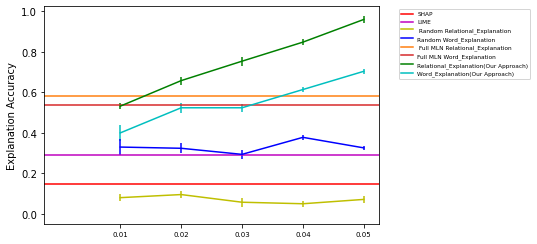

In [49]:
# Varying Clusters and Models



#figures [0.334, 0.312, 0.28400000000000003, 0.268, 0.218]
#[0.0461519230368573, 0.084970583144992, 0.029664793948382655, 0.06140032573203501, 0.0363318042491699]

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import sys
import pylab 
x1 = np.linspace(0, 20, 1000)


sw=[0.8975, 0.9025000000000001, 0.89, 0.9075, 0.8875]
swv=[0.015000000000000012, 0.025000000000000022, 0.021602468994692887, 0.012583057392117927, 0.03500000000000003]#[0.0017000000000000008, 0.0006300000000000011, 0.00043000000000000075, 0.00013000000000000023, 0.00013000000000000023] #[0.45,0.52,0.55,0.61,0.70]
#sw1=[0.45,0.49,0.58,0.65,0.72] #0.15,0.29,
#srm1=[0.54,0.65,0.71,0.78,0.92]
src1=[0.8775000000000001, 0.8725, 0.81, 0.77, 0.87]
src1v=[0.025000000000000022, 0.012909944487358068, 0.034999999999999984, 0.021961524227066326, 0.026299556396765858]#[0.0002700000000000005, 0.00037000000000000065, 0.0004800000000000009, 0.0002200000000000004, 0.00025000000000000044]
rc1=[0.59, 0.635, 0.6174999999999999, 0.6475, 0.6525]
rc1v=[0.018257418583505554, 0.005773502691896263, 0.020615528128088322, 0.022173557826083472, 0.040311288741492736]

rc2=[0.6950000000000001, 0.6775, 0.555, 0.725, 0.675]
rc2v=[0.026457513110645873, 0.07410578025138571, 0.03696845502136471, 0.04203173404306164, 0.04654746681256313]
#[0.33, 0.324, 0.29400000000000004, 0.378, 0.326]
#[0.08031189202104505, 0.09555103348473003, 0.057706152185014035, 0.050199601592044535, 0.07162401831787994]
#relation
#[0.334, 0.312, 0.28400000000000003, 0.268, 0.218]
#[0.0461519230368573, 0.084970583144992, 0.029664793948382655, 0.06140032573203501, 0.0363318042491699]
x2=0
y2=0
#plt.title('Comparison of accuracy of  feed back and without feedback using  bagging model with respect to annotated data')

#plt.grid(True)
#Lc1=['SHAP','LIME','20-Cluster','40-Cluster','60-Cluster','80-Cluster','100-Cluster']
#Lc1=['SHAP','LIME','25-Models','50-Models','100-Models','200-Models','300-Models']#['SVM','Extra_Trees','Bagging','RandomForest','Decision_Tress']
#Lc1=['0.01','0.02','0.03','0.04','0.05']
Lc1=['0.03','0.07','0.15','0.30','0.40']

#plt.hist(L22,density=100, bins=200) 
#plt.axis([0,6,0,50]) 
#axis([xmin,xmax,ymin,ymax])
#txt="Our Approach vs LIME for Spam"

# make some synthetic data


#fig = plt.figure()
#fig.text(.5, .015, txt, ha='center')
#plt.xlabel('Q6,Q7 and Q8 ')
#plt.xlabel('Reviews ')
plt.ylabel("Explanation Accuracy")
#plt.ylabel("True Positive")
x = np.array([0,1,2,3,4])
ax = plt.subplot(111)
ax1 = plt.subplot(111)
ax2 = plt.subplot(111)
ax3 = plt.subplot(111)

############
v = np.array(sw)
x = [1,2,3,4,5]
yr = swv
ax.errorbar(x,v,yerr=yr,color='c')
v1 = np.array(src1)
x1 = [1,2,3,4,5]
yr1 = src1v
ax1.errorbar(x1,v1,yerr=yr1,color='g')
#########
v3 = np.array(rc1)
x3 = [1,2,3,4,5]
yr3 = rc1v
ax2.errorbar(x3,v3,yerr=yr3,color='b')
v4 = np.array(rc2)
x4 = [1,2,3,4,5]
yr4 = rc2v
ax3.errorbar(x4,v4,yerr=yr4,color='y')


#######
#plt.show()
#ax.errorbar(x2,y2, e2, linestyle='None', marker='|',color='g')
#ax1.errorbar(x1,y1,e1, linestyle='None', marker='|',color='c')
plt.axhline(y=0.16,linestyle='-',color='r', xmin=0.0)
plt.axhline(y=0.24,linestyle='-',color='m', xmin=0.0)
#plt.axhline(y=0.40,linestyle='-',color='b', xmin=0.0)
#plt.axhline(y=0.35,linestyle='-',color='y', xmin=0.0)
plt.axhline(y=0.41,linestyle='-',color='C3', xmin=0.0)
plt.axhline(y=0.77,linestyle='-',color='C1', xmin=0.0)

#ax2.axhline(y= 0.15, color = 'rgb', linestyle = '-') 
#ax3.axhline(y = 0.29, color = 'bg', linestyle = '-') 
#ax.bar(x-0.30,k,width=0.15,color='g',align='center')
#ax.bar(x-0.15,e,width=0.15,color='b',align='center')
#ax.bar(x,r,width=0.15,color='m',align='center')
#ax.bar(x+0.15,b,width=0.15,color='c',align='center')
#ax.bar(x+0.60,cl20,width=0.30,color='y',align='center')
pylab.plot(x2, y2, '-r', label='SHAP')
pylab.plot(x2,y2, '-m', label='LIME')
pylab.plot(x2,y2, '-y', label=' R-Explain (Relation)')
pylab.plot(x2,y2, '-b', label='R-Explain (Word)')
pylab.plot(x2,y2, '-C1', label='M-Explain (Relation)')
pylab.plot(x2,y2, '-C3', label='M-Explain (Word)')
pylab.plot(x2,y2, '-g', label='I-Explain (Relation)')
pylab.plot(x2,y2, '-c', label='I-Explain (Word)')
#pylab.plot(x2,y2, '-c', label='Bagging')
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

fontP = FontProperties()
fontP.set_size('xx-small')
pylab.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)

#plt.bar(x,pre)
#plt1.bar(x,re)
plt.xticks(x,Lc1)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)
plt.savefig("Review_Varying_Models_Acuracy_up3.pdf",bbox_inches="tight")
plt.show()
pylab.show()


In [256]:
# Per Query Acuuray based on the explanation with gradual increase

def mln_gen(kk5,kk6):
      
                            # model per query accuracy
                            wr={}
                            for t in Sample_model:
                                gh=[]
                                for k in Sample_model[t]:
                                    if 'Same' not in k[0]:
                                        gh.append(k[0])
                                wr[t]=gh
                            for v in wr:
                                pass#print(v,wr[v])
                            wrr={}
                            for t in Sample_model:
                                gh1=[]
                                for k in Sample_model[t]:
                                    if 'Same'  in k[0]:
                                        #print(k[0])
                                        gh1.append(k[0])
                                wrr[t]=gh1

                            for v in wrr:
                                 print(v,wrr[v])
                            #Evidence Update and relation update
                            #def evd_updat(inc)
                            WORDS23={}
                            import math

                            rel={}
                            for t in wrr:
                                        #print(t,len(reliab_exp_up_1r_pc[t]))
                                        gh=[]
                                        c=0
                                        z=int(math.ceil(len(wrr[t])*kk5))
                                        for j in wrr[t]:
                                            if c<z:
                                                #if str(j) in WORDS23:
                                                        gh.append(j)
                                                        c=c+1
                                        if len(gh)!=0:
                                             rel[t]=gh
                            for t in wr:
                                if t in rel:
                                        gh=[]
                                        c=0
                                        z=int(math.ceil(len(wr[t])*kk5))
                                        for j in wr[t]:
                                            if c<z:
                                                gh.append(j)
                                                c=c+1

                                        WORDS23[t]=gh
                            for k in rel:
                                print(k,WORDS23[k],rel[k])




                            #relation
                            sa=[]
                            for t in rel:
                                for kk in rel[t]:
                                    print(kk)
                                    sa.append(kk)



                            #MLN Generator
                            w=[]
                            ir=[]
                            ir.append("positive(x)")
                            ir.append("negative(x)")  
                            #ir.append("positive(y)")
                            #ir.append("negative(y)")  
                            ir.append("Sameuser(x,y)")
                            ir.append("Samehotel(x,y)")
                            for t in WORDS23:
                                for k in WORDS23[t]:
                                    if k not in w:
                                        w.append(k)
                                        hh="HasWord_"+str(k)+"(x)"
                                        ir.append(hh)
                            fr=[]
                            r1="1.0 "+"!positive(x)"+" v "+"!Sameuser(x,y)"+" v "+"!positive(y)"
                            r2="1.0 "+"!negative(x)"+" v "+"!Sameuser(x,y)"+" v "+"!negative(y)"
                            r11="1.0 "+"!positive(x)"+" v "+"!Samehotel(x,y)"+" v "+"!positive(y)"
                            r12="1.0 "+"!negative(x)"+" v "+"!Samehotel(x,y)"+" v "+"!negative(y)"
                            fr.append(r1)
                            fr.append(r2)
                            fr.append(r11)
                            fr.append(r12)
                            for tt in w:
                                if len(r_wts[tt])==3:
                                    if r_wts[tt][2]!=0:
                                        fg=str(r_wts[tt][2])+" "+"!HasWord_"+str(tt)+"(x)"+" v "+"positive(x)"
                                        fr.append(fg)
                                    if r_wts[tt][0]!=0:
                                        fg1=str(r_wts[tt][0])+" "+"!HasWord_"+str(tt)+"(x)"+" v "+"negative(x)"
                                        fr.append(fg1)
                            vbc="mln"+str(kk6)+".txt"

                            f1=open(vbc,"w")
                            for t in ir:
                                f1.write(str(t)+"\n")
                            f1.write("\n\n")
                            for t in fr:
                                f1.write(str(t)+"\n")

                            f1.close()

                            #evidence
                            ev=[]
                            for t in WORDS23:
                                for k in WORDS23[t]:
                                        hh="HasWord_"+str(k)+"("+str(t)+")"
                                        print(hh)
                                        ev.append(hh)
                            vbc1="evid"+str(kk6)+".txt"
                            f2=open(vbc1,"w")
                            for gg in ev:
                                f2.write(str(gg)+"\n")
                            for gg1 in sa:
                                f2.write(str(gg1)+"\n")
                            f2.close()




for j in range(1,11,1):
    bb=float(j)/10
    vvvv=mln_gen(bb,j)
    

1467 ['Sameuser(1467,4495)', 'Sameuser(1467,4358)', 'Samehotel(1467,1466)']
2668 ['Sameuser(2668,1300)', 'Sameuser(2668,867)', 'Sameuser(2668,348)', 'Sameuser(2668,3109)', 'Sameuser(2668,381)']
352 ['Sameuser(352,366)', 'Samehotel(352,353)']
34 ['Sameuser(34,321)', 'Sameuser(34,557)', 'Samehotel(34,35)', 'Samehotel(34,36)']
2231 ['Sameuser(2231,351)', 'Sameuser(2231,728)']
763 ['Sameuser(763,174)', 'Sameuser(763,2020)', 'Sameuser(763,698)', 'Samehotel(763,760)', 'Samehotel(763,753)', 'Samehotel(763,752)', 'Samehotel(763,757)']
20 ['Samehotel(20,19)']
3460 ['Samehotel(3460,3458)']
522 ['Samehotel(522,526)', 'Samehotel(522,539)', 'Samehotel(522,524)', 'Samehotel(522,525)', 'Samehotel(522,529)', 'Samehotel(522,532)', 'Samehotel(522,523)', 'Samehotel(522,540)']
3019 ['Sameuser(3019,554)', 'Sameuser(3019,190)', 'Sameuser(3019,1051)']
132 ['Samehotel(132,138)', 'Samehotel(132,136)', 'Samehotel(132,135)', 'Samehotel(132,133)', 'Samehotel(132,131)']
36 ['Sameuser(36,552)', 'Sameuser(36,224)', 

728 ['service'] ['Sameuser(728,2231)']
1508 ['really'] ['Sameuser(1508,31)']
986 ['food'] ['Sameuser(986,138)']
433 ['even'] ['Sameuser(433,263)', 'Sameuser(433,1696)']
382 ['small'] ['Samehotel(382,381)']
61 ['food'] ['Sameuser(61,407)']
1563 ['hard'] ['Samehotel(1563,1564)']
455 ['went'] ['Sameuser(455,2529)']
3262 ['ordered'] ['Sameuser(3262,231)']
655 ['food'] ['Sameuser(655,1818)']
2336 ['way'] ['Sameuser(2336,742)']
2000 ['ate'] ['Sameuser(2000,1184)']
1168 ['order'] ['Sameuser(1168,540)']
131 ['thing'] ['Sameuser(131,1748)']
1454 ['felt'] ['Sameuser(1454,2351)']
723 ['find'] ['Samehotel(723,717)']
859 ['walk'] ['Samehotel(859,861)']
320 ['restaurant'] ['Sameuser(320,2277)']
618 ['got'] ['Samehotel(618,617)']
266 ['since'] ['Sameuser(266,2913)']
3597 ['better'] ['Sameuser(3597,139)']
1510 ['pizza'] ['Sameuser(1510,5095)']
1568 ['better'] ['Sameuser(1568,238)']
326 ['even'] ['Sameuser(326,2173)']
874 ['steak'] ['Sameuser(874,47)']
989 ['got'] ['Samehotel(989,993)']
3815 ['experien

Sameuser(1783,2338)
Sameuser(150,2109)
Samehotel(150,146)
Sameuser(496,1061)
Sameuser(33,613)
Sameuser(145,785)
Samehotel(145,148)
Sameuser(208,119)
Samehotel(264,262)
Sameuser(1560,16)
Sameuser(3142,1631)
Sameuser(1854,749)
Sameuser(4867,682)
Samehotel(148,171)
Samehotel(148,162)
Sameuser(3762,108)
Sameuser(737,505)
Sameuser(484,5105)
Sameuser(637,78)
Sameuser(374,691)
Sameuser(2845,119)
Sameuser(337,3929)
Sameuser(135,162)
Sameuser(357,375)
Sameuser(493,4085)
Samehotel(597,599)
Sameuser(691,374)
Sameuser(1326,1351)
Sameuser(331,226)
Sameuser(389,3316)
Sameuser(554,1051)
Sameuser(2510,2161)
Sameuser(362,1121)
Sameuser(324,369)
Sameuser(504,3408)
Sameuser(699,1147)
Sameuser(1527,599)
Sameuser(414,325)
Sameuser(113,2095)
Sameuser(454,1855)
Sameuser(327,179)
Sameuser(346,189)
Sameuser(406,318)
Samehotel(339,336)
Sameuser(4948,403)
Sameuser(4859,228)
Sameuser(3386,76)
Sameuser(142,3831)
Sameuser(207,694)
Sameuser(1818,655)
Sameuser(1902,2466)
Sameuser(886,357)
Sameuser(564,2584)
Sameuser(

680 ['Samehotel(680,691)', 'Samehotel(680,683)', 'Samehotel(680,688)', 'Samehotel(680,685)', 'Samehotel(680,694)', 'Samehotel(680,698)', 'Samehotel(680,684)', 'Samehotel(680,682)']
4315 ['Sameuser(4315,440)', 'Sameuser(4315,1261)', 'Samehotel(4315,4314)']
1300 ['Sameuser(1300,867)', 'Sameuser(1300,348)', 'Sameuser(1300,3109)', 'Sameuser(1300,381)', 'Sameuser(1300,2668)']
187 ['Sameuser(187,555)', 'Samehotel(187,182)', 'Samehotel(187,184)', 'Samehotel(187,188)']
546 ['Sameuser(546,725)', 'Sameuser(546,563)']
638 ['Sameuser(638,5278)', 'Sameuser(638,2221)', 'Sameuser(638,2509)', 'Samehotel(638,639)']
351 ['Sameuser(351,2231)', 'Sameuser(351,728)']
1631 ['Sameuser(1631,3142)', 'Sameuser(1631,1245)']
1773 ['Sameuser(1773,848)', 'Sameuser(1773,62)']
3831 ['Sameuser(3831,142)', 'Sameuser(3831,404)']
732 ['Sameuser(732,697)']
477 ['Sameuser(477,5022)', 'Sameuser(477,1894)', 'Samehotel(477,475)', 'Samehotel(477,476)', 'Samehotel(477,473)']
3052 ['Sameuser(3052,1783)', 'Sameuser(3052,2338)', 'S

725 ['sure'] ['Sameuser(725,546)']
1233 ['worth'] ['Sameuser(1233,1203)']
3048 ['table'] ['Sameuser(3048,267)']
3937 ['food'] ['Sameuser(3937,416)']
138 ['food'] ['Sameuser(138,986)', 'Samehotel(138,131)']
698 ['hard'] ['Sameuser(698,2020)', 'Sameuser(698,763)', 'Sameuser(698,174)']
3316 ['know'] ['Sameuser(3316,389)']
120 ['tasted'] ['Samehotel(120,122)']
673 ['food'] ['Sameuser(673,6)']
3919 ['order'] ['Sameuser(3919,3799)']
168 ['got'] ['Samehotel(168,162)', 'Samehotel(168,148)', 'Samehotel(168,152)']
179 ['ordered'] ['Sameuser(179,327)']
3130 ['food'] ['Sameuser(3130,1276)']
4717 ['better'] ['Sameuser(4717,451)']
3598 ['ordered'] ['Sameuser(3598,303)']
403 ['nothing'] ['Sameuser(403,4948)', 'Sameuser(403,2847)']
574 ['even'] ['Sameuser(574,2)']
408 ['small'] ['Sameuser(408,850)']
416 ['good'] ['Sameuser(416,5306)']
487 ['order'] ['Sameuser(487,279)']
551 ['food'] ['Sameuser(551,549)']
190 ['fries'] ['Sameuser(190,3019)']
152 ['people'] ['Sameuser(152,2716)', 'Sameuser(152,383)', 'S

HasWord_food(5228)
HasWord_order(592)
HasWord_order(171)
HasWord_drinks(644)
HasWord_got(2439)
HasWord_food(697)
HasWord_pretty(4479)
HasWord_come(163)
HasWord_will(31)
HasWord_food(1979)
HasWord_good(656)
HasWord_came(188)
HasWord_felt(1148)
HasWord_much(355)
HasWord_even(1855)
HasWord_order(2103)
HasWord_food(488)
HasWord_soup(93)
HasWord_way(29)
HasWord_stars(903)
HasWord_maybe(3251)
HasWord_meat(508)
HasWord_food(451)
HasWord_got(511)
HasWord_hard(1805)
HasWord_food(1526)
HasWord_still(1245)
HasWord_food(4545)
HasWord_back(431)
HasWord_nothing(402)
HasWord_even(2267)
HasWord_drinks(659)
HasWord_food(1206)
HasWord_taste(1254)
HasWord_food(329)
HasWord_way(2117)
HasWord_food(1060)
HasWord_food(1768)
HasWord_will(1016)
HasWord_since(27)
HasWord_even(679)
HasWord_nothing(770)
HasWord_pizza(4020)
HasWord_looking(616)
HasWord_pick(552)
HasWord_food(1018)
HasWord_food(4)
HasWord_pizza(2311)
HasWord_know(369)
HasWord_chicken(1044)
HasWord_food(4534)
HasWord_food(614)
HasWord_better(475)
Ha

5023 ['price', 'work'] ['Sameuser(5023,236)']
2203 ['got', 'seated'] ['Sameuser(2203,29)']
365 ['wanted', 'think'] ['Sameuser(365,2688)']
458 ['first', 'pretty'] ['Sameuser(458,741)']
4008 ['flavor', 'come'] ['Sameuser(4008,2103)']
1014 ['nothing', 'may'] ['Sameuser(1014,3604)', 'Sameuser(1014,2359)', 'Sameuser(1014,2658)']
1701 ['sandwich', 'much'] ['Sameuser(1701,4552)']
1863 ['food', 'however'] ['Sameuser(1863,19)', 'Samehotel(1863,1866)']
501 ['tried', 'price'] ['Sameuser(501,146)', 'Sameuser(501,108)']
917 ['got', 'really'] ['Sameuser(917,50)']
736 ['food', 'nothing'] ['Samehotel(736,737)']
2056 ['ordered', 'table'] ['Sameuser(2056,1001)']
507 ['food', 'nice'] ['Sameuser(507,5078)', 'Samehotel(507,510)']
949 ['clear', 'food'] ['Sameuser(949,2155)']
2514 ['hard', 'however'] ['Sameuser(2514,155)', 'Sameuser(2514,653)']
2847 ['food', 'small'] ['Sameuser(2847,4948)']
510 ['ok', 'roasted'] ['Samehotel(510,507)']
4421 ['another', 'food'] ['Sameuser(4421,3408)']
2956 ['food', 'much'] ['S

Sameuser(722,3267)
Sameuser(722,506)
Sameuser(1594,5135)
Sameuser(5058,3736)
Sameuser(4912,9)
Sameuser(3973,993)
Sameuser(3973,529)
Sameuser(683,575)
Samehotel(683,691)
Samehotel(683,688)
Sameuser(581,4264)
Sameuser(581,2313)
Sameuser(540,1168)
Sameuser(540,387)
Samehotel(540,526)
Sameuser(1928,2437)
Samehotel(1928,1919)
Samehotel(388,392)
Sameuser(1965,241)
Sameuser(267,4934)
Sameuser(267,3048)
Samehotel(267,260)
Samehotel(154,162)
Samehotel(154,171)
Samehotel(154,145)
Samehotel(154,148)
Sameuser(1121,362)
Sameuser(164,997)
Sameuser(164,30)
Samehotel(164,148)
Samehotel(164,152)
Samehotel(164,162)
Sameuser(375,886)
Sameuser(1879,4004)
Sameuser(1868,181)
Sameuser(1868,376)
Sameuser(1868,439)
Sameuser(3736,5058)
Sameuser(1243,640)
Sameuser(1243,2423)
Sameuser(1243,787)
Samehotel(325,326)
Sameuser(518,3239)
Samehotel(518,515)
Sameuser(258,428)
Sameuser(258,1768)
Samehotel(258,262)
Sameuser(640,1243)
Sameuser(640,2423)
Sameuser(640,787)
Samehotel(2194,2203)
Sameuser(440,1261)
Sameuser(440,

478 ['Sameuser(478,1121)', 'Sameuser(478,362)', 'Sameuser(478,52)']
4294 ['Sameuser(4294,715)', 'Sameuser(4294,1801)', 'Sameuser(4294,499)', 'Sameuser(4294,560)', 'Sameuser(4294,675)']
1294 []
526 ['Sameuser(526,1016)', 'Samehotel(526,529)', 'Samehotel(526,540)', 'Samehotel(526,539)', 'Samehotel(526,524)', 'Samehotel(526,525)', 'Samehotel(526,523)', 'Samehotel(526,522)', 'Samehotel(526,532)']
2646 ['Sameuser(2646,2102)']
1740 ['Samehotel(1740,1737)']
2697 ['Sameuser(2697,504)', 'Sameuser(2697,3408)', 'Sameuser(2697,4421)']
4473 ['Sameuser(4473,634)']
3220 []
423 ['Samehotel(423,431)', 'Samehotel(423,440)', 'Samehotel(423,425)', 'Samehotel(423,436)', 'Samehotel(423,435)', 'Samehotel(423,428)', 'Samehotel(423,439)']
1920 ['Samehotel(1920,1919)', 'Samehotel(1920,1912)', 'Samehotel(1920,1928)', 'Samehotel(1920,1924)']
578 ['Samehotel(578,575)', 'Samehotel(578,580)', 'Samehotel(578,574)', 'Samehotel(578,581)']
321 ['Sameuser(321,34)', 'Sameuser(321,557)', 'Samehotel(321,320)']
670 ['Samehot

285 ['order', 'good'] ['Sameuser(285,617)', 'Sameuser(285,1532)']
476 ['food', 'will'] ['Sameuser(476,5166)', 'Samehotel(476,475)']
1980 ['enough', 'much'] ['Samehotel(1980,1979)']
850 ['ordered', 'really'] ['Sameuser(850,408)', 'Sameuser(850,3522)', 'Samehotel(850,861)']
342 ['food', 'hard'] ['Samehotel(342,344)']
715 ['sandwich', 'good'] ['Sameuser(715,560)', 'Sameuser(715,499)']
3761 ['order', 'good'] ['Samehotel(3761,3770)', 'Samehotel(3761,3762)']
599 ['cheese', 'mind'] ['Sameuser(599,1436)', 'Sameuser(599,1527)', 'Sameuser(599,1625)']
1680 ['know', 'say'] ['Sameuser(1680,605)']
1037 ['nothing', 'think'] ['Sameuser(1037,3299)']
104 ['better', 'got'] ['Sameuser(104,1638)', 'Sameuser(104,355)']
231 ['rather', 'food'] ['Sameuser(231,15)', 'Sameuser(231,3262)', 'Samehotel(231,227)', 'Samehotel(231,225)']
2871 ['pretty', 'much'] ['Sameuser(2871,196)']
3801 ['got', 'enough'] ['Sameuser(3801,1196)']
3237 ['guys', 'even'] ['Sameuser(3237,328)', 'Sameuser(3237,609)']
459 ['ordered', 'good'

Sameuser(1037,3299)
Sameuser(104,1638)
Sameuser(104,355)
Sameuser(231,15)
Sameuser(231,3262)
Samehotel(231,227)
Samehotel(231,225)
Sameuser(2871,196)
Sameuser(3801,1196)
Sameuser(3237,328)
Sameuser(3237,609)
Sameuser(459,189)
Sameuser(459,346)
Samehotel(5091,5095)
Sameuser(612,98)
Sameuser(119,208)
Sameuser(119,2845)
Sameuser(119,1254)
Sameuser(379,166)
Sameuser(379,2117)
Samehotel(1383,1385)
Sameuser(1036,4829)
Sameuser(523,455)
Sameuser(523,2529)
Sameuser(523,69)
Samehotel(523,526)
Samehotel(523,525)
Sameuser(236,3025)
Sameuser(532,155)
Sameuser(532,653)
Sameuser(532,2514)
Samehotel(532,526)
Samehotel(532,525)
Sameuser(560,715)
Sameuser(560,1801)
Sameuser(2146,3763)
Sameuser(2146,674)
Sameuser(262,89)
Samehotel(262,260)
Samehotel(262,263)
Sameuser(1194,4034)
Sameuser(5078,507)
Sameuser(5154,300)
Sameuser(1842,2161)
Sameuser(1842,2510)
Sameuser(1061,496)
Sameuser(1078,1816)
Sameuser(57,194)
Samehotel(57,54)
Samehotel(57,62)
Samehotel(57,59)
Sameuser(626,2550)
Samehotel(626,624)
Sameus

HasWord_good(280)
HasWord_place(280)
HasWord_came(4516)
HasWord_table(4516)
HasWord_sure(725)
HasWord_years(725)
HasWord_worth(1233)
HasWord_flavor(1233)
HasWord_table(3048)
HasWord_around(3048)
HasWord_food(3937)
HasWord_pretty(3937)
HasWord_food(138)
HasWord_bread(138)
HasWord_hard(698)
HasWord_nice(698)
HasWord_know(3316)
HasWord_people(3316)
HasWord_tasted(120)
HasWord_flavor(120)
HasWord_food(673)
HasWord_cheese(673)
HasWord_order(3919)
HasWord_service(3919)
HasWord_got(168)
HasWord_worth(168)
HasWord_ordered(179)
HasWord_ever(179)
HasWord_food(3130)
HasWord_better(3130)
HasWord_better(4717)
HasWord_got(4717)
HasWord_ordered(3598)
HasWord_hard(3598)
HasWord_nothing(403)
HasWord_still(403)
HasWord_even(574)
HasWord_hard(574)
HasWord_small(408)
HasWord_though(408)
HasWord_good(416)
HasWord_go(416)
HasWord_order(487)
HasWord_got(487)
HasWord_food(551)
HasWord_really(551)
HasWord_fries(190)
HasWord_really(190)
HasWord_people(152)
HasWord_time(152)
HasWord_outside(279)
HasWord_good(279

580 ['Sameuser(580,1868)', 'Sameuser(580,439)', 'Sameuser(580,181)', 'Sameuser(580,376)', 'Samehotel(580,575)', 'Samehotel(580,574)', 'Samehotel(580,581)', 'Samehotel(580,578)']
1051 ['Sameuser(1051,554)', 'Sameuser(1051,190)', 'Sameuser(1051,3019)']
1659 ['Sameuser(1659,1991)', 'Sameuser(1659,3425)', 'Sameuser(1659,4901)', 'Samehotel(1659,1670)']
473 ['Sameuser(473,3635)', 'Samehotel(473,475)', 'Samehotel(473,477)', 'Samehotel(473,476)']
1781 ['Sameuser(1781,595)', 'Sameuser(1781,745)', 'Samehotel(1781,1783)']
2509 ['Sameuser(2509,5278)', 'Sameuser(2509,638)', 'Sameuser(2509,2221)', 'Samehotel(2509,2510)']
703 ['Sameuser(703,260)']
312 ['Sameuser(312,35)', 'Sameuser(312,329)', 'Sameuser(312,1970)']
5278 ['Sameuser(5278,638)', 'Sameuser(5278,2221)', 'Sameuser(5278,2509)']
1184 ['Sameuser(1184,3251)', 'Sameuser(1184,2000)', 'Samehotel(1184,1187)', 'Samehotel(1184,1183)']
5071 ['Sameuser(5071,5135)', 'Sameuser(5071,1594)']
2153 ['Sameuser(2153,4020)']
1242 ['Sameuser(1242,92)']
563 ['Sam

2509 ['ordered', 'came', 'chicken'] ['Sameuser(2509,5278)', 'Sameuser(2509,638)']
703 ['will', 'little', 'place'] ['Sameuser(703,260)']
312 ['food', 'order', 'ordered'] ['Sameuser(312,35)', 'Sameuser(312,329)']
5278 ['small', 'restaurant', 'nice'] ['Sameuser(5278,638)', 'Sameuser(5278,2221)']
1184 ['food', 'got', 'ordered'] ['Sameuser(1184,3251)', 'Sameuser(1184,2000)']
5071 ['food', 'know', 'went'] ['Sameuser(5071,5135)']
2153 ['really', 'chicken', 'day'] ['Sameuser(2153,4020)']
1242 ['fine', 'offer', 'ordered'] ['Sameuser(1242,92)']
563 ['food', 'nice', 'good'] ['Sameuser(563,546)']
2275 ['food', 'really', 'eat'] ['Sameuser(2275,1818)', 'Sameuser(2275,3095)']
4660 ['better', 'nothing', 'got'] ['Sameuser(4660,1073)', 'Sameuser(4660,1901)']
368 ['pretty', 'service', 'good'] ['Samehotel(368,366)']
1147 ['give', 'taste', 'little'] ['Sameuser(1147,699)', 'Sameuser(1147,572)']
435 ['food', 'service', 'time'] ['Sameuser(435,650)', 'Samehotel(435,431)', 'Samehotel(435,425)', 'Samehotel(435,4

HasWord_food(2697)
HasWord_however(2697)
HasWord_say(2697)
HasWord_worth(4473)
HasWord_went(4473)
HasWord_around(4473)
HasWord_went(423)
HasWord_sauce(423)
HasWord_bit(423)
HasWord_first(1920)
HasWord_nice(1920)
HasWord_make(1920)
HasWord_food(578)
HasWord_small(578)
HasWord_come(578)
HasWord_came(321)
HasWord_two(321)
HasWord_french(321)
HasWord_small(670)
HasWord_pretty(670)
HasWord_nice(670)
HasWord_pretty(2155)
HasWord_good(2155)
HasWord_place(2155)
HasWord_food(98)
HasWord_wanted(98)
HasWord_cheese(98)
HasWord_better(3578)
HasWord_even(3578)
HasWord_ordered(3578)
HasWord_food(4922)
HasWord_meat(4922)
HasWord_will(4922)
HasWord_food(1696)
HasWord_ordered(1696)
HasWord_really(1696)
HasWord_pretty(364)
HasWord_stars(364)
HasWord_area(364)
HasWord_restaurant(1130)
HasWord_good(1130)
HasWord_time(1130)
HasWord_food(2908)
HasWord_unfortunately(2908)
HasWord_space(2908)
HasWord_go(239)
HasWord_place(239)
HasWord_one(239)
HasWord_pretty(711)
HasWord_cold(711)
HasWord_cheese(711)
HasWord_e

HasWord_since(717)
HasWord_came(717)
HasWord_really(717)
HasWord_food(456)
HasWord_much(456)
HasWord_cold(456)
HasWord_got(609)
HasWord_ordered(609)
HasWord_go(609)
HasWord_good(571)
HasWord_loved(571)
HasWord_inexpensive(571)
HasWord_service(621)
HasWord_go(621)
HasWord_great(621)
HasWord_food(5105)
HasWord_table(5105)
HasWord_brunch(5105)
HasWord_enough(225)
HasWord_pretty(225)
HasWord_much(225)
HasWord_order(2182)
HasWord_taste(2182)
HasWord_came(2182)
HasWord_want(155)
HasWord_really(155)
HasWord_sauce(155)
HasWord_food(44)
HasWord_still(44)
HasWord_bread(44)
HasWord_food(158)
HasWord_worth(158)
HasWord_nice(158)
HasWord_experience(1901)
HasWord_want(1901)
HasWord_lot(1901)
HasWord_food(2351)
HasWord_ago(2351)
HasWord_mac(2351)
HasWord_got(383)
HasWord_back(383)
HasWord_nice(383)
HasWord_food(2221)
HasWord_order(2221)
HasWord_service(2221)
HasWord_really(439)
HasWord_little(439)
HasWord_two(439)
HasWord_friends(425)
HasWord_chicken(425)
HasWord_best(425)
HasWord_probably(542)
HasWo

402 ['Sameuser(402,55)', 'Sameuser(402,320)', 'Sameuser(402,2277)', 'Samehotel(402,400)', 'Samehotel(402,406)', 'Samehotel(402,404)', 'Samehotel(402,396)', 'Samehotel(402,393)', 'Samehotel(402,403)']
2267 ['Sameuser(2267,592)']
659 ['Sameuser(659,3062)', 'Sameuser(659,133)', 'Samehotel(659,662)']
1206 ['Sameuser(1206,247)', 'Sameuser(1206,1350)', 'Sameuser(1206,396)', 'Sameuser(1206,1429)']
1254 ['Sameuser(1254,2845)', 'Sameuser(1254,208)', 'Sameuser(1254,119)', 'Samehotel(1254,1249)', 'Samehotel(1254,1245)', 'Samehotel(1254,1261)', 'Samehotel(1254,1243)', 'Samehotel(1254,1244)', 'Samehotel(1254,1252)']
329 ['Sameuser(329,35)', 'Sameuser(329,1970)', 'Sameuser(329,312)', 'Samehotel(329,328)', 'Samehotel(329,331)']
2117 ['Sameuser(2117,166)', 'Sameuser(2117,379)', 'Samehotel(2117,2111)', 'Samehotel(2117,2103)', 'Samehotel(2117,2108)', 'Samehotel(2117,2109)']
1060 ['Sameuser(1060,2056)', 'Sameuser(1060,1001)']
1768 ['Sameuser(1768,428)', 'Sameuser(1768,258)']
1016 ['Sameuser(1016,526)', '

787 ['food', 'pretty', 'service'] ['Sameuser(787,2423)', 'Sameuser(787,640)']
516 ['food', 'good', 'go'] ['Sameuser(516,550)', 'Samehotel(516,515)', 'Samehotel(516,519)']
302 ['food', 'ordered', 'though'] ['Sameuser(302,494)']
366 ['got', 'looking', 'cheese'] ['Sameuser(366,352)', 'Samehotel(366,368)']
692 ['food', 'order', 'really'] ['Sameuser(692,438)', 'Sameuser(692,1018)', 'Sameuser(692,1395)', 'Sameuser(692,172)', 'Sameuser(692,380)', 'Samehotel(692,688)', 'Samehotel(692,691)', 'Samehotel(692,683)', 'Samehotel(692,685)']
572 ['much', 'way', 'nice'] ['Sameuser(572,1147)', 'Sameuser(572,699)']
2688 ['service', 'take', 'good'] ['Sameuser(2688,365)', 'Sameuser(2688,219)']
4579 ['table', 'went', 'times'] ['Sameuser(4579,2659)', 'Samehotel(4579,4573)']
688 ['small', 'much', 'chicken'] ['Sameuser(688,1252)', 'Samehotel(688,683)', 'Samehotel(688,691)', 'Samehotel(688,698)', 'Samehotel(688,684)', 'Samehotel(688,682)']
252 ['better', 'will', 'side'] ['Sameuser(252,230)', 'Sameuser(252,3244)

Samehotel(578,575)
Samehotel(578,580)
Samehotel(578,574)
Sameuser(321,34)
Sameuser(321,557)
Samehotel(670,671)
Sameuser(2155,2243)
Sameuser(2155,949)
Sameuser(98,612)
Sameuser(3578,4382)
Sameuser(4922,2409)
Sameuser(1696,288)
Sameuser(1696,263)
Samehotel(364,365)
Sameuser(1130,299)
Sameuser(2908,44)
Sameuser(239,1183)
Samehotel(239,238)
Sameuser(711,488)
Sameuser(711,2777)
Sameuser(711,1564)
Sameuser(1140,1912)
Sameuser(1140,4509)
Sameuser(587,619)
Samehotel(4573,4579)
Sameuser(648,4321)
Samehotel(648,640)
Samehotel(648,644)
Sameuser(4552,1701)
Samehotel(344,342)
Sameuser(2095,113)
Sameuser(2095,254)
Sameuser(1813,386)
Sameuser(1813,431)
Sameuser(1813,2759)
Samehotel(3458,3460)
Sameuser(4514,228)
Sameuser(4514,4859)
Samehotel(684,691)
Samehotel(684,694)
Samehotel(684,683)
Samehotel(684,688)
Samehotel(684,699)
Sameuser(912,2155)
Sameuser(912,949)
Sameuser(3522,408)
Sameuser(3522,850)
Samehotel(227,225)
Samehotel(227,230)
Samehotel(227,224)
Samehotel(227,228)
Sameuser(2665,4960)
Samehote

Sameuser(1243,640)
Sameuser(1243,2423)
Sameuser(1243,787)
Samehotel(1243,1249)
Samehotel(1243,1261)
Samehotel(1243,1245)
Samehotel(325,326)
Sameuser(325,414)
Sameuser(518,3239)
Samehotel(518,515)
Samehotel(518,519)
Sameuser(258,428)
Sameuser(258,1768)
Samehotel(258,262)
Samehotel(258,266)
Samehotel(258,260)
Sameuser(640,1243)
Sameuser(640,2423)
Sameuser(640,787)
Samehotel(640,650)
Samehotel(640,644)
Samehotel(2194,2203)
Sameuser(440,1261)
Sameuser(440,4315)
Samehotel(440,431)
Samehotel(440,423)
Samehotel(440,439)
Sameuser(69,455)
Sameuser(69,2529)
Sameuser(69,523)
Samehotel(69,73)
Samehotel(268,270)
Sameuser(452,1525)
Sameuser(2108,642)
Sameuser(2108,679)
Samehotel(2108,2117)
Samehotel(2108,2103)
Sameuser(1001,1060)
Sameuser(1001,2056)
Sameuser(4960,2665)
Sameuser(4829,1036)
Samehotel(4829,4828)
Sameuser(627,492)
Sameuser(627,1581)
Sameuser(2466,1902)
Sameuser(2466,4866)
Samehotel(2466,2465)
Sameuser(529,109)
Sameuser(529,3770)
Sameuser(529,3973)
Sameuser(529,993)
Samehotel(529,523)
Sa

HasWord_looking(637)
HasWord_came(374)
HasWord_us(374)
HasWord_back(374)
HasWord_food(2845)
HasWord_order(2845)
HasWord_came(2845)
HasWord_food(337)
HasWord_know(337)
HasWord_say(337)
HasWord_portion(135)
HasWord_enjoyed(135)
HasWord_packed(135)
HasWord_food(357)
HasWord_service(357)
HasWord_go(357)
HasWord_good(493)
HasWord_little(493)
HasWord_love(493)
HasWord_food(597)
HasWord_good(597)
HasWord_bit(597)
HasWord_small(691)
HasWord_restaurant(691)
HasWord_nice(691)
HasWord_pretty(1326)
HasWord_really(1326)
HasWord_one(1326)
HasWord_drinks(331)
HasWord_seated(331)
HasWord_friends(331)
HasWord_area(389)
HasWord_side(389)
HasWord_seating(389)
HasWord_better(554)
HasWord_even(554)
HasWord_think(554)
HasWord_things(2510)
HasWord_fine(2510)
HasWord_average(2510)
HasWord_food(362)
HasWord_come(362)
HasWord_us(362)
HasWord_time(324)
HasWord_warm(324)
HasWord_great(324)
HasWord_food(504)
HasWord_minutes(504)
HasWord_top(504)
HasWord_sure(699)
HasWord_dish(699)
HasWord_two(699)
HasWord_think(15

166 ['Sameuser(166,379)', 'Sameuser(166,2117)', 'Samehotel(166,148)', 'Samehotel(166,162)', 'Samehotel(166,152)', 'Samehotel(166,151)', 'Samehotel(166,174)', 'Samehotel(166,145)', 'Samehotel(166,154)', 'Samehotel(166,155)', 'Samehotel(166,150)', 'Samehotel(166,146)', 'Samehotel(166,171)', 'Samehotel(166,164)', 'Samehotel(166,158)', 'Samehotel(166,160)']
742 ['Sameuser(742,2336)', 'Sameuser(742,400)', 'Samehotel(742,741)', 'Samehotel(742,745)', 'Samehotel(742,749)']
700 []
30 ['Sameuser(30,997)', 'Sameuser(30,164)', 'Samehotel(30,29)', 'Samehotel(30,26)', 'Samehotel(30,22)']
4483 []
1783 ['Sameuser(1783,2338)', 'Sameuser(1783,3052)', 'Sameuser(1783,46)', 'Samehotel(1783,1781)']
150 ['Sameuser(150,2109)', 'Samehotel(150,146)', 'Samehotel(150,148)', 'Samehotel(150,145)', 'Samehotel(150,154)', 'Samehotel(150,155)', 'Samehotel(150,151)', 'Samehotel(150,162)', 'Samehotel(150,160)', 'Samehotel(150,174)', 'Samehotel(150,152)', 'Samehotel(150,158)', 'Samehotel(150,171)', 'Samehotel(150,168)']
4

27 ['since', 'around', 'long', 'place'] ['Sameuser(27,5091)', 'Samehotel(27,22)', 'Samehotel(27,30)', 'Samehotel(27,26)', 'Samehotel(27,29)']
679 ['even', 'really', 'back', 'place'] ['Sameuser(679,2108)', 'Sameuser(679,642)']
770 ['nothing', 'got', 'though', 'say'] ['Sameuser(770,671)', 'Sameuser(770,3753)']
4020 ['pizza', 'better', 'line', 'price'] ['Sameuser(4020,2153)']
616 ['looking', 'big', 'everything', 'night'] ['Samehotel(616,617)', 'Samehotel(616,618)', 'Samehotel(616,619)']
552 ['pick', 'think', 'nice', 'meal'] ['Sameuser(552,36)', 'Sameuser(552,224)', 'Samehotel(552,557)', 'Samehotel(552,555)']
1018 ['food', 'order', 'back', 'one'] ['Sameuser(1018,692)', 'Sameuser(1018,380)', 'Sameuser(1018,172)', 'Sameuser(1018,1395)', 'Sameuser(1018,438)', 'Samehotel(1018,1016)']
4 ['food', 'nothing', 'ordered', 'great'] ['Samehotel(4,2)', 'Samehotel(4,6)']
2311 ['pizza', 'got', 'line', 'take'] ['Samehotel(2311,2313)']
369 ['know', 'taste', 'ordered', 'chicken'] ['Sameuser(369,324)']
1044 

Sameuser(1894,5022)
Sameuser(1068,542)
Sameuser(1068,8)
Sameuser(741,458)
Samehotel(741,742)
Samehotel(741,745)
Sameuser(619,587)
Samehotel(619,617)
Samehotel(619,616)
Sameuser(575,683)
Samehotel(575,574)
Samehotel(575,580)
Samehotel(575,581)
Samehotel(654,653)
Sameuser(654,1569)
Samehotel(270,268)
Sameuser(515,90)
Samehotel(515,518)
Samehotel(515,519)
Samehotel(515,517)
Sameuser(1230,941)
Samehotel(1230,1233)
Sameuser(241,1965)
Sameuser(241,915)
Sameuser(16,1560)
Samehotel(16,15)
Samehotel(16,8)
Samehotel(16,10)
Sameuser(9,4912)
Samehotel(9,15)
Samehotel(9,16)
Samehotel(9,8)
Sameuser(184,571)
Samehotel(184,182)
Samehotel(184,187)
Sameuser(675,715)
Sameuser(675,499)
Sameuser(675,1801)
Sameuser(675,4294)
Sameuser(517,874)
Sameuser(517,1731)
Sameuser(517,47)
Samehotel(517,515)
Samehotel(517,519)
Sameuser(5166,476)
Samehotel(5166,5165)
Sameuser(4934,267)
Sameuser(4934,3048)
Sameuser(6,673)
Sameuser(6,472)
Samehotel(6,2)
Sameuser(809,54)
Samehotel(902,903)
Sameuser(1183,239)
Samehotel(1183

HasWord_still(4321)
HasWord_table(4321)
HasWord_pork(4321)
HasWord_service(219)
HasWord_dessert(219)
HasWord_rice(219)
HasWord_spiced(219)
HasWord_thing(4264)
HasWord_hour(4264)
HasWord_good(4264)
HasWord_wait(4264)
HasWord_came(1436)
HasWord_really(1436)
HasWord_cheese(1436)
HasWord_pork(1436)
HasWord_time(634)
HasWord_place(634)
HasWord_wait(634)
HasWord_super(634)
HasWord_small(4034)
HasWord_chicken(4034)
HasWord_nice(4034)
HasWord_one(4034)
HasWord_came(720)
HasWord_come(720)
HasWord_people(720)
HasWord_take(720)
HasWord_food(1203)
HasWord_much(1203)
HasWord_place(1203)
HasWord_wait(1203)
HasWord_food(2252)
HasWord_decent(2252)
HasWord_thought(2252)
HasWord_cheese(2252)
HasWord_really(2138)
HasWord_service(2138)
HasWord_waitress(2138)
HasWord_good(2138)
HasWord_even(1912)
HasWord_though(1912)
HasWord_good(1912)
HasWord_little(1912)
HasWord_will(710)
HasWord_people(710)
HasWord_good(710)
HasWord_one(710)
HasWord_bread(91)
HasWord_went(91)
HasWord_bit(91)
HasWord_warm(91)
HasWord_fir

HasWord_one(699)
HasWord_think(1527)
HasWord_though(1527)
HasWord_really(1527)
HasWord_way(1527)
HasWord_know(414)
HasWord_time(414)
HasWord_place(414)
HasWord_one(414)
HasWord_way(113)
HasWord_make(113)
HasWord_best(113)
HasWord_well(113)
HasWord_first(454)
HasWord_sauce(454)
HasWord_bar(454)
HasWord_also(454)
HasWord_food(327)
HasWord_ordered(327)
HasWord_really(327)
HasWord_cheese(327)
HasWord_food(346)
HasWord_back(346)
HasWord_go(346)
HasWord_also(346)
HasWord_want(406)
HasWord_say(406)
HasWord_went(406)
HasWord_go(406)
HasWord_food(339)
HasWord_left(339)
HasWord_chicken(339)
HasWord_bite(339)
HasWord_food(4948)
HasWord_meal(4948)
HasWord_atmosphere(4948)
HasWord_yes(4948)
HasWord_cafe(4859)
HasWord_least(4859)
HasWord_something(4859)
HasWord_around(4859)
HasWord_restaurant(3386)
HasWord_never(3386)
HasWord_looking(3386)
HasWord_ever(3386)
HasWord_food(142)
HasWord_stars(142)
HasWord_will(142)
HasWord_high(142)
HasWord_service(207)
HasWord_time(207)
HasWord_dinner(207)
HasWord_man

264 ['Samehotel(264,262)', 'Samehotel(264,263)', 'Samehotel(264,266)', 'Samehotel(264,258)', 'Samehotel(264,260)', 'Samehotel(264,267)']
1560 ['Sameuser(1560,16)']
3142 ['Sameuser(3142,1631)', 'Sameuser(3142,1245)']
1613 []
1854 ['Sameuser(1854,749)', 'Sameuser(1854,2568)', 'Sameuser(1854,519)']
4867 ['Sameuser(4867,682)']
4818 []
148 ['Samehotel(148,171)', 'Samehotel(148,162)', 'Samehotel(148,146)', 'Samehotel(148,151)', 'Samehotel(148,152)', 'Samehotel(148,145)', 'Samehotel(148,150)', 'Samehotel(148,158)', 'Samehotel(148,166)', 'Samehotel(148,174)', 'Samehotel(148,154)', 'Samehotel(148,153)', 'Samehotel(148,155)', 'Samehotel(148,160)', 'Samehotel(148,168)']
3762 ['Sameuser(3762,108)', 'Sameuser(3762,501)', 'Sameuser(3762,2532)', 'Sameuser(3762,146)', 'Samehotel(3762,3770)', 'Samehotel(3762,3761)', 'Samehotel(3762,3763)']
737 ['Sameuser(737,505)', 'Samehotel(737,736)', 'Samehotel(737,734)']
484 ['Sameuser(484,5105)', 'Samehotel(484,485)', 'Samehotel(484,482)']
637 ['Sameuser(637,78)']

1970 ['pretty', 'really', 'restaurant', 'one'] ['Sameuser(1970,329)', 'Sameuser(1970,35)', 'Sameuser(1970,312)']
3425 ['food', 'think', 'cold', 'wait'] ['Sameuser(3425,1659)', 'Sameuser(3425,1991)', 'Sameuser(3425,4901)']
717 ['since', 'came', 'really', 'good'] ['Samehotel(717,720)', 'Samehotel(717,723)', 'Samehotel(717,718)', 'Samehotel(717,722)']
456 ['food', 'much', 'cold', 'perfect'] ['Sameuser(456,2252)', 'Samehotel(456,457)', 'Samehotel(456,455)']
609 ['got', 'ordered', 'go', 'place'] ['Sameuser(609,328)', 'Sameuser(609,3237)']
571 ['good', 'loved', 'inexpensive', 'great'] ['Samehotel(571,572)', 'Sameuser(571,184)']
621 ['service', 'go', 'great', 'also'] ['Sameuser(621,5005)', 'Samehotel(621,620)']
5105 ['food', 'table', 'brunch', 'make'] ['Sameuser(5105,484)']
225 ['enough', 'pretty', 'much', 'good'] ['Sameuser(225,1466)', 'Samehotel(225,228)', 'Samehotel(225,231)', 'Samehotel(225,230)', 'Samehotel(225,224)', 'Samehotel(225,226)']
2182 ['order', 'taste', 'came', 'back'] ['Sameus

Samehotel(683,685)
Samehotel(683,694)
Samehotel(683,698)
Samehotel(683,684)
Sameuser(581,4264)
Sameuser(581,2313)
Samehotel(581,575)
Samehotel(581,574)
Samehotel(581,578)
Sameuser(540,1168)
Sameuser(540,387)
Samehotel(540,526)
Samehotel(540,539)
Samehotel(540,523)
Samehotel(540,524)
Samehotel(540,525)
Samehotel(540,529)
Sameuser(1928,2437)
Samehotel(1928,1919)
Samehotel(1928,1912)
Samehotel(1928,1920)
Samehotel(388,392)
Samehotel(388,389)
Sameuser(1965,241)
Sameuser(1965,915)
Sameuser(267,4934)
Sameuser(267,3048)
Samehotel(267,260)
Samehotel(267,266)
Samehotel(267,264)
Samehotel(267,262)
Samehotel(154,162)
Samehotel(154,171)
Samehotel(154,145)
Samehotel(154,148)
Samehotel(154,150)
Samehotel(154,158)
Samehotel(154,166)
Samehotel(154,152)
Samehotel(154,146)
Sameuser(1121,362)
Sameuser(1121,52)
Sameuser(1121,478)
Sameuser(164,997)
Sameuser(164,30)
Samehotel(164,148)
Samehotel(164,152)
Samehotel(164,162)
Samehotel(164,171)
Samehotel(164,150)
Samehotel(164,145)
Samehotel(164,174)
Samehotel(

HasWord_much(867)
HasWord_restaurant(867)
HasWord_little(867)
HasWord_way(5005)
HasWord_last(5005)
HasWord_try(5005)
HasWord_pork(5005)
HasWord_order(4828)
HasWord_ordered(4828)
HasWord_came(4828)
HasWord_time(4828)
HasWord_ordered(436)
HasWord_think(436)
HasWord_ambiance(436)
HasWord_eggs(436)
HasWord_enough(46)
HasWord_though(46)
HasWord_really(46)
HasWord_people(46)
HasWord_food(2409)
HasWord_think(2409)
HasWord_service(2409)
HasWord_table(2409)
HasWord_unfortunately(1549)
HasWord_brunch(1549)
HasWord_atmosphere(1549)
HasWord_two(1549)
HasWord_ordered(861)
HasWord_really(861)
HasWord_good(861)
HasWord_recommend(861)
HasWord_food(1681)
HasWord_order(1681)
HasWord_really(1681)
HasWord_good(1681)
HasWord_better(5135)
HasWord_really(5135)
HasWord_restaurant(5135)
HasWord_try(5135)
HasWord_sandwich(2423)
HasWord_will(2423)
HasWord_take(2423)
HasWord_go(2423)
HasWord_pretty(1155)
HasWord_came(1155)
HasWord_nice(1155)
HasWord_time(1155)
HasWord_food(494)
HasWord_loved(494)
HasWord_place(49

2095 ['Sameuser(2095,113)', 'Sameuser(2095,254)']
1813 ['Sameuser(1813,386)', 'Sameuser(1813,431)', 'Sameuser(1813,2759)', 'Samehotel(1813,1814)']
3458 ['Samehotel(3458,3460)']
4514 ['Sameuser(4514,228)', 'Sameuser(4514,4859)', 'Samehotel(4514,4516)']
2395 []
684 ['Samehotel(684,691)', 'Samehotel(684,694)', 'Samehotel(684,683)', 'Samehotel(684,688)', 'Samehotel(684,699)', 'Samehotel(684,685)', 'Samehotel(684,698)']
912 ['Sameuser(912,2155)', 'Sameuser(912,949)', 'Sameuser(912,2243)']
3522 ['Sameuser(3522,408)', 'Sameuser(3522,850)']
227 ['Samehotel(227,225)', 'Samehotel(227,230)', 'Samehotel(227,224)', 'Samehotel(227,228)', 'Samehotel(227,231)', 'Samehotel(227,226)']
2665 ['Sameuser(2665,4960)', 'Samehotel(2665,2659)', 'Samehotel(2665,2658)']
336 ['Sameuser(336,1055)', 'Samehotel(336,339)', 'Samehotel(336,337)']
624 ['Sameuser(624,480)', 'Samehotel(624,626)', 'Samehotel(624,627)']
444 []
174 ['Sameuser(174,763)', 'Sameuser(174,698)', 'Sameuser(174,2020)', 'Samehotel(174,148)', 'Samehot

543 ['back', 'little', 'time', 'place', 'great'] ['Sameuser(543,4265)', 'Samehotel(543,542)']
617 ['order', 'since', 'service', 'take', 'night'] ['Sameuser(617,1532)', 'Sameuser(617,285)', 'Samehotel(617,618)', 'Samehotel(617,616)', 'Samehotel(617,619)']
685 ['flavor', 'dining', 'brunch', 'time', 'perfect'] ['Sameuser(685,73)', 'Sameuser(685,107)', 'Sameuser(685,160)', 'Samehotel(685,691)', 'Samehotel(685,698)', 'Samehotel(685,683)', 'Samehotel(685,688)', 'Samehotel(685,680)', 'Samehotel(685,682)', 'Samehotel(685,684)']
146 ['around', 'good', 'wait', 'right', 'well'] ['Sameuser(146,3762)', 'Sameuser(146,501)', 'Sameuser(146,108)', 'Sameuser(146,2532)', 'Samehotel(146,148)', 'Samehotel(146,150)', 'Samehotel(146,152)', 'Samehotel(146,155)', 'Samehotel(146,174)', 'Samehotel(146,145)', 'Samehotel(146,151)', 'Samehotel(146,154)', 'Samehotel(146,162)']
438 ['food', 'pretty', 'place', 'wait', 'menu'] ['Sameuser(438,692)', 'Sameuser(438,380)', 'Sameuser(438,172)', 'Sameuser(438,1018)', 'Sameus

Sameuser(2243,949)
Samehotel(2243,2252)
Sameuser(1252,688)
Samehotel(1252,1261)
Samehotel(1252,1254)
Samehotel(1252,1244)
Samehotel(1252,1243)
Samehotel(1252,1249)
Samehotel(1252,1245)
Sameuser(109,529)
Sameuser(109,3973)
Sameuser(109,3770)
Sameuser(109,993)
Samehotel(109,110)
Samehotel(109,108)
Sameuser(139,3597)
Samehotel(620,621)
Sameuser(620,489)
Sameuser(620,1427)
Sameuser(1026,4479)
Sameuser(189,459)
Sameuser(189,346)
Samehotel(189,190)
Sameuser(189,588)
Sameuser(5095,1510)
Samehotel(5095,5091)
Samehotel(198,194)
Samehotel(198,193)
Samehotel(198,196)
Samehotel(457,456)
Sameuser(457,2956)
Samehotel(457,455)
Samehotel(66,73)
Samehotel(66,76)
Samehotel(66,69)
Sameuser(595,745)
Sameuser(595,1781)
Samehotel(595,599)
Samehotel(595,597)
Samehotel(595,592)
Sameuser(848,62)
Sameuser(848,1773)
Samehotel(848,859)
Samehotel(848,861)
Samehotel(848,850)
Samehotel(848,845)
Samehotel(848,867)
Sameuser(915,1965)
Sameuser(915,241)
Sameuser(299,1130)
Samehotel(299,300)
Sameuser(110,569)
Sameuser(11

Samehotel(737,736)
Samehotel(737,734)
Sameuser(484,5105)
Samehotel(484,485)
Samehotel(484,482)
Sameuser(637,78)
Sameuser(374,691)
Sameuser(374,1866)
Samehotel(374,370)
Sameuser(2845,119)
Sameuser(2845,1254)
Sameuser(2845,208)
Sameuser(337,3929)
Sameuser(337,4069)
Samehotel(337,336)
Samehotel(337,339)
Sameuser(135,162)
Samehotel(135,136)
Samehotel(135,138)
Samehotel(135,131)
Samehotel(135,132)
Samehotel(135,133)
Sameuser(357,375)
Sameuser(357,886)
Samehotel(357,362)
Samehotel(357,355)
Samehotel(357,360)
Sameuser(493,4085)
Samehotel(493,494)
Samehotel(493,492)
Samehotel(493,489)
Samehotel(493,491)
Samehotel(597,599)
Samehotel(597,592)
Samehotel(597,595)
Sameuser(691,374)
Sameuser(691,1866)
Samehotel(691,683)
Samehotel(691,684)
Samehotel(691,688)
Samehotel(691,685)
Samehotel(691,694)
Samehotel(691,682)
Samehotel(691,699)
Sameuser(1326,1351)
Sameuser(1326,278)
Sameuser(331,226)
Sameuser(331,465)
Samehotel(331,329)
Samehotel(331,328)
Sameuser(389,3316)
Samehotel(389,388)
Samehotel(389,392)


HasWord_ordered(495)
HasWord_really(495)
HasWord_good(495)
HasWord_great(495)
HasWord_menu(495)
HasWord_really(55)
HasWord_good(55)
HasWord_place(55)
HasWord_glad(55)
HasWord_love(55)
HasWord_enough(549)
HasWord_really(549)
HasWord_cold(549)
HasWord_good(549)
HasWord_delicious(549)
HasWord_really(467)
HasWord_service(467)
HasWord_sauce(467)
HasWord_place(467)
HasWord_also(467)
HasWord_pretty(409)
HasWord_say(409)
HasWord_place(409)
HasWord_wait(409)
HasWord_best(409)
HasWord_dry(2658)
HasWord_food(2658)
HasWord_small(2658)
HasWord_brunch(2658)
HasWord_menu(2658)
HasWord_small(668)
HasWord_pretty(668)
HasWord_good(668)
HasWord_side(668)
HasWord_recommend(668)
HasWord_meat(5229)
HasWord_chicken(5229)
HasWord_sauce(5229)
HasWord_best(5229)
HasWord_amazing(5229)
HasWord_pretty(1737)
HasWord_really(1737)
HasWord_take(1737)
HasWord_good(1737)
HasWord_make(1737)
HasWord_though(260)
HasWord_really(260)
HasWord_good(260)
HasWord_wait(260)
HasWord_great(260)
HasWord_order(4809)
HasWord_got(4809)

2668 ['Sameuser(2668,1300)', 'Sameuser(2668,867)', 'Sameuser(2668,348)', 'Sameuser(2668,3109)', 'Sameuser(2668,381)']
352 ['Sameuser(352,366)', 'Samehotel(352,353)']
34 ['Sameuser(34,321)', 'Sameuser(34,557)', 'Samehotel(34,35)', 'Samehotel(34,36)']
2231 ['Sameuser(2231,351)', 'Sameuser(2231,728)']
763 ['Sameuser(763,174)', 'Sameuser(763,2020)', 'Sameuser(763,698)', 'Samehotel(763,760)', 'Samehotel(763,753)', 'Samehotel(763,752)', 'Samehotel(763,757)']
20 ['Samehotel(20,19)']
3460 ['Samehotel(3460,3458)']
522 ['Samehotel(522,526)', 'Samehotel(522,539)', 'Samehotel(522,524)', 'Samehotel(522,525)', 'Samehotel(522,529)', 'Samehotel(522,532)', 'Samehotel(522,523)', 'Samehotel(522,540)']
3019 ['Sameuser(3019,554)', 'Sameuser(3019,190)', 'Sameuser(3019,1051)']
132 ['Samehotel(132,138)', 'Samehotel(132,136)', 'Samehotel(132,135)', 'Samehotel(132,133)', 'Samehotel(132,131)']
36 ['Sameuser(36,552)', 'Sameuser(36,224)', 'Samehotel(36,35)', 'Samehotel(36,34)']
1385 ['Sameuser(1385,1020)', 'Sameho

1814 ['food', 'way', 'hour', 'french', 'sweet'] ['Samehotel(1814,1813)']
4037 ['disappointed', 'ordered', 'stars', 'sauce', 'pork'] ['Sameuser(4037,303)', 'Sameuser(4037,639)', 'Sameuser(4037,3598)', 'Sameuser(4037,475)', 'Sameuser(4037,1805)']
52 ['really', 'time', 'every', 'warm', 'great'] ['Sameuser(52,1121)', 'Sameuser(52,478)', 'Sameuser(52,362)', 'Samehotel(52,62)', 'Samehotel(52,59)', 'Samehotel(52,61)', 'Samehotel(52,57)', 'Samehotel(52,65)', 'Samehotel(52,47)', 'Samehotel(52,54)', 'Samehotel(52,55)']
561 ['really', 'go', 'place', 'see', 'also'] ['Sameuser(561,495)']
1749 ['order', 'really', 'good', 'cheese', 'one'] ['Samehotel(1749,1748)']
2487 ['got', 'service', 'go', 'time', 'delicious'] ['Sameuser(2487,1748)', 'Sameuser(2487,131)']
5165 ['nothing', 'ordered', 'went', 'great', 'also'] ['Samehotel(5165,5166)']
230 ['really', 'nice', 'good', 'one', 'cozy'] ['Sameuser(230,252)', 'Sameuser(230,3244)', 'Samehotel(230,231)', 'Samehotel(230,226)', 'Samehotel(230,228)', 'Samehotel(2

Samehotel(231,230)
Samehotel(231,224)
Samehotel(231,226)
Sameuser(2871,196)
Sameuser(3801,1196)
Samehotel(3801,3799)
Sameuser(3237,328)
Sameuser(3237,609)
Samehotel(3237,3239)
Samehotel(3237,3244)
Sameuser(459,189)
Sameuser(459,346)
Sameuser(459,588)
Samehotel(459,458)
Samehotel(459,460)
Samehotel(5091,5095)
Sameuser(5091,27)
Sameuser(612,98)
Samehotel(612,613)
Sameuser(119,208)
Sameuser(119,2845)
Sameuser(119,1254)
Samehotel(119,122)
Samehotel(119,118)
Samehotel(119,120)
Sameuser(379,166)
Sameuser(379,2117)
Samehotel(379,380)
Samehotel(1383,1385)
Samehotel(1383,1395)
Sameuser(1036,4829)
Samehotel(1036,1037)
Sameuser(523,455)
Sameuser(523,2529)
Sameuser(523,69)
Samehotel(523,526)
Samehotel(523,525)
Samehotel(523,539)
Samehotel(523,529)
Samehotel(523,540)
Samehotel(523,522)
Samehotel(523,524)
Samehotel(523,532)
Sameuser(236,3025)
Sameuser(236,5023)
Sameuser(532,155)
Sameuser(532,653)
Sameuser(532,2514)
Samehotel(532,526)
Samehotel(532,525)
Samehotel(532,524)
Samehotel(532,529)
Samehotel

Sameuser(627,492)
Sameuser(627,1581)
Samehotel(627,624)
Sameuser(2466,1902)
Sameuser(2466,4866)
Samehotel(2466,2465)
Samehotel(2466,2462)
Sameuser(529,109)
Sameuser(529,3770)
Sameuser(529,3973)
Sameuser(529,993)
Samehotel(529,523)
Samehotel(529,524)
Samehotel(529,526)
Samehotel(529,539)
Samehotel(529,525)
Samehotel(529,522)
Samehotel(529,540)
Samehotel(529,532)
Sameuser(2659,4579)
Samehotel(2659,2665)
Samehotel(2659,2658)
Sameuser(2162,564)
Sameuser(2162,4881)
Sameuser(2162,2584)
Sameuser(3929,337)
Sameuser(3929,4069)
Sameuser(472,6)
Sameuser(472,673)
Sameuser(2102,2646)
Sameuser(2109,150)
Samehotel(2109,2103)
Samehotel(2109,2108)
Samehotel(2109,2111)
Samehotel(2109,2117)
Sameuser(3635,473)
Sameuser(1073,1901)
Sameuser(1073,657)
Sameuser(1073,4660)
Sameuser(37,4521)
Sameuser(1801,4294)
Sameuser(1801,499)
Sameuser(1801,560)
Sameuser(1801,715)
Sameuser(1801,675)
Sameuser(3025,236)
Sameuser(3025,5023)
Sameuser(318,1528)
Sameuser(318,406)
Sameuser(318,467)
Samehotel(318,315)
Sameuser(181,4

HasWord_well(572)
HasWord_service(2688)
HasWord_take(2688)
HasWord_good(2688)
HasWord_many(2688)
HasWord_excellent(2688)
HasWord_table(4579)
HasWord_went(4579)
HasWord_times(4579)
HasWord_place(4579)
HasWord_everyone(4579)
HasWord_small(688)
HasWord_much(688)
HasWord_chicken(688)
HasWord_delicious(688)
HasWord_menu(688)
HasWord_better(252)
HasWord_will(252)
HasWord_side(252)
HasWord_brunch(252)
HasWord_great(252)
HasWord_order(8)
HasWord_come(8)
HasWord_place(8)
HasWord_now(8)
HasWord_friend(8)
HasWord_food(182)
HasWord_good(182)
HasWord_time(182)
HasWord_bar(182)
HasWord_amazing(182)
HasWord_food(50)
HasWord_though(50)
HasWord_definitely(50)
HasWord_loved(50)
HasWord_best(50)
HasWord_pretty(278)
HasWord_came(278)
HasWord_back(278)
HasWord_wait(278)
HasWord_delicious(278)
HasWord_order(315)
HasWord_go(315)
HasWord_place(315)
HasWord_one(315)
HasWord_menu(315)
HasWord_place(589)
HasWord_bar(589)
HasWord_love(589)
HasWord_also(589)
HasWord_menu(589)
HasWord_think(3299)
HasWord_go(3299)
H

HasWord_bad(4867)
HasWord_food(4867)
HasWord_tasted(4867)
HasWord_pretty(4867)
HasWord_say(4867)
HasWord_enough(148)
HasWord_pretty(148)
HasWord_good(148)
HasWord_little(148)
HasWord_delicious(148)
HasWord_order(3762)
HasWord_thought(3762)
HasWord_fish(3762)
HasWord_lunch(3762)
HasWord_loved(3762)
HasWord_better(737)
HasWord_got(737)
HasWord_eat(737)
HasWord_sauce(737)
HasWord_try(737)
HasWord_got(484)
HasWord_take(484)
HasWord_good(484)
HasWord_best(484)
HasWord_spot(484)
HasWord_seated(637)
HasWord_service(637)
HasWord_looking(637)
HasWord_good(637)
HasWord_great(637)
HasWord_came(374)
HasWord_us(374)
HasWord_back(374)
HasWord_time(374)
HasWord_one(374)
HasWord_food(2845)
HasWord_order(2845)
HasWord_came(2845)
HasWord_us(2845)
HasWord_little(2845)
HasWord_food(337)
HasWord_know(337)
HasWord_say(337)
HasWord_back(337)
HasWord_night(337)
HasWord_portion(135)
HasWord_enjoyed(135)
HasWord_packed(135)
HasWord_absolutely(135)
HasWord_salad(135)
HasWord_food(357)
HasWord_service(357)
HasWor

In [ ]:
#tuffy marginal
pp=[]
ff=open("qryinf100.txt")
for d in ff:
    ss=d.strip("\n").split()
    if float(ss[0])>=0.8:
                #print(ss[0],ss[1])
                pp.append(ss[1])
pr1=[]
tr1=[]
for j in pp:
    jj=j.strip(")").split("(")
    #print(dtt[jj[0]])
    #print(dtt[jj[0]],qrat[int(jj[1])])
    pr1.append(dtt[jj[0]])
    
    if qrat[int(jj[1])]==2 or qrat[int(jj[1])]==1:
        tr1.append(2)
    else:
        tr1.append(0)
from sklearn.metrics import f1_score
pp=f1_score(tr1, pr1, average='micro')
print(pp)  
cc=0
for t in range(0,len(tr1)):
        if tr1[t]==pr1[t]:
            cc=cc+1
print(cc/len(tr1))

In [ ]:
# Table Error Bars Covid
import statistics
def our():
        mn={}
        mn[1]=[0.83,0.8,0.84]
        mn[2]=[0.70,0.73,0.66]
        mn[3]=[0.74,0.73,0.75]
        mn[4]=[0.75,0.72,0.73]
        mn[5]=[0.76,0.75,0.77]
        mn[6]=[0.78,0.75,0.74]
        mn[7]=[0.73,0.70,0.72]
        mn[8]=[0.72,0.75,0.71]
        mn[9]=[0.74,0.73,0.74]
        mn[10]=[0.73,0.75,0.72]
        import statistics
        from statistics import stdev

        mm=[]
        mv=[]
        tt=[]
        for t in mn:
            b=max(mn[t])
            bb=statistics.mean(mn[t])
            bb1=stdev(mn[t])
            mm.append(bb)
            mv.append(bb1)
            tt.append(b)
        #print(mm)
        #print(mv)
        bs=max(tt)
        return mn[1],mv,bs
def rn():
        mn={}
        mn[1]=[0.52,0.65,0.59]
        mn[2]=[0.56,0.53,0.61]
        mn[3]=[0.45,0.57,0.50]
        mn[4]=[0.61,0.52,0.56]
        mn[5]=[0.65,0.57,0.62]
        mn[6]=[0.50,0.59,0.51]
        mn[7]=[0.57,0.58,0.61]
        mn[8]=[0.61,.66,0.59]
        mn[9]=[0.59,0.53,0.58]
        mn[10]=[0.59,0.64,0.56]
        import statistics
        from statistics import stdev

        mm=[]
        mv=[]
        tt=[]
        for t in mn:
            b=max(mn[t])
            bb=statistics.mean(mn[t])
            bb1=stdev(mn[t])
            mm.append(bb)
            mv.append(bb1)
            tt.append(b)
        #print(mm)
        #print(mv)
        bs=max(tt)
        return mn[1],mv,bs
def fl():
        mn={}
        mn[1]=[0.63,0.62,0.62]
        mn[2]=[0.67,0.64,0.65]
        mn[3]=[0.59,0.60,0.60]
        mn[4]=[0.55,0.58,0.54]
        mn[5]=[0.53,0.53,0.51]
        mn[6]=[0.58,0.57,0.61]
        mn[7]=[0.65,0.62,0.62]
        mn[8]=[0.58,0.58,0.57]
        mn[9]=[0.63,0.57,0.62]
        mn[10]=[0.62,0.62,0.64]
        import statistics
        from statistics import stdev

        mm=[]
        mv=[]
        tt=[]
        for t in mn:
            b=max(mn[t])
            bb=statistics.mean(mn[t])
            bb1=stdev(mn[t])
            mm.append(bb)
            mv.append(bb1)
            tt.append(b)
        #print(mm)
        #print(mv)
        bs=max(tt)
        return mn[1],mv,bs
def sh():
        mn={}
        mn[1]=[0.41,0.37,0.39]
        mn[2]=[0.28,0.30,0.32]
        mn[3]=[0.35,0.41,0.39]
        mn[4]=[0.44,0.42,0.39]
        mn[5]=[0.42,0.45,0.47]
        mn[6]=[0.46,0.49,0.49]
        mn[7]=[0.54,0.51,0.52]
        mn[8]=[0.49,0.50,0.50]
        mn[9]=[0.50,0.53,0.49]
        mn[10]=[0.52,0.52,0.43]
        import statistics
        from statistics import stdev

        mm=[]
        mv=[]
        tt=[]
        for t in mn:
            b=max(mn[t])
            bb=statistics.mean(mn[t])
            bb1=stdev(mn[t])
            mm.append(bb)
            mv.append(bb1)
            tt.append(b)
        #print(mm)
        #print(mv)
        bs=max(tt)
        return mn[1],mv,bs
def lm():
        mn={}
        mn[1]=[0.52,0.54,0.54]
        mn[2]=[0.52,0.55,0.54]
        mn[3]=[0.53,0.51,0.52]
        mn[4]=[0.51,0.54,0.49]
        mn[5]=[0.49,0.50,0.51]
        mn[6]=[0.54,0.55,0.55]
        mn[7]=[0.52,0.51,0.49]
        mn[8]=[0.56,0.56,0.55]
        mn[9]=[0.49,0.48,0.50]
        mn[10]=[0.53,0.53,0.53]
        import statistics
        from statistics import stdev

        mm=[]
        mv=[]
       
        tt=[]
        for t in mn:
            b=max(mn[t])
            bb=statistics.mean(mn[t])
            bb1=stdev(mn[t])
            mm.append(bb)
            mv.append(bb1)
            tt.append(b)
        #print(mm)
        #print(mv)
        bs=max(tt)
        return mn[1],mv,bs
om,ov,p1=our()
rm,rv,p2=rn()
fm,fv,p3=fl()
sm,sv,p4=sh()
lm,lv,p5=lm()

print("I-Explain")
print(statistics.mean(om),statistics.mean(ov),p1)

print("R-Explain")
print(statistics.mean(rm),statistics.mean(rv),p2)

print("M-Explain")
print(statistics.mean(fm),statistics.mean(fv),p3)

print("SHAP-Explain")
print(statistics.mean(sm),statistics.mean(sv),p4)

print("LIME-Explain")
print(statistics.mean(lm),statistics.mean(lv),p5)


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

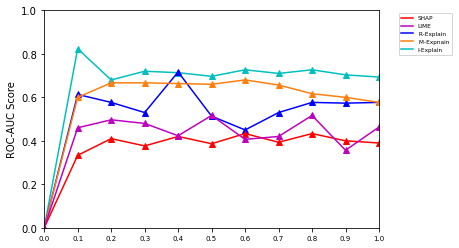

In [147]:
#[0.83,0.70,0.74,0.75,0.71,0.78,0.73,0.72,0.74,0.71] 1
#[0.8,0.68,0.67,0.68,0.7,0.71,0.68,0.75,0.68,0.69]
#[0.84,0.66,0.75,0.71,0.68,0.69,0.72,0.71,0.69,0.68] 
#plt.savefig("Topic_Varying_Clusters_Acuracy_up3.pdf",bbox_inches="tight")
#ERROR BAR Varying Explanations
def our():
        mn={}
        mn[1]=[0.83,0.8,0.84]
        mn[2]=[0.70,0.73,0.66]
        mn[3]=[0.74,0.73,0.75]
        mn[4]=[0.75,0.72,0.73]
        mn[5]=[0.76,0.75,0.77]
        mn[6]=[0.78,0.75,0.74]
        mn[7]=[0.73,0.70,0.72]
        mn[8]=[0.72,0.75,0.71]
        mn[9]=[0.74,0.73,0.74]
        mn[10]=[0.73,0.75,0.72]
        import statistics
        from statistics import stdev

        mm=[]
        mv=[]
        mm.append(0)
        mv.append(0)
        for t in mn:
            bb=statistics.mean(mn[t])
            bb1=stdev(mn[t])
            mm.append(bb)
            mv.append(bb1)
        #print(mm)
        #print(mv)
        return mm,mv
def rn():
        mn={}
        mn[1]=[0.67,0.51,0.66]
        mn[2]=[0.51,0.73,0.49]
        mn[3]=[0.43,0.57,0.59]
        mn[4]=[0.68,0.70,0.77]
        mn[5]=[0.55,0.47,0.52]
        mn[6]=[0.40,0.39,0.56]
        mn[7]=[0.43,0.55,0.61]
        mn[8]=[0.69,.49,0.55]
        mn[9]=[0.49,0.55,0.68]
        mn[10]=[0.51,0.64,0.58]
        import statistics
        from statistics import stdev

        mm=[]
        mv=[]
        mm.append(0)
        mv.append(0)
        for t in mn:
            bb=statistics.mean(mn[t])
            bb1=stdev(mn[t])
            mm.append(bb)
            mv.append(bb1)
        #print(mm)
        #print(mv)
        return mm,mv
def fl():
        mn={}
        mn[1]=[0.59,0.60,0.61]
        mn[2]=[0.66,0.68,0.66]
        mn[3]=[0.65,0.67,0.68]
        mn[4]=[0.65,0.67,0.67]
        mn[5]=[0.64,0.68,0.66]
        mn[6]=[0.68,0.69,0.67]
        mn[7]=[0.67,0.65,0.65]
        mn[8]=[0.61,0.62,0.62]
        mn[9]=[0.59,0.60,0.61]
        mn[10]=[0.59,0.56,0.58]
        import statistics
        from statistics import stdev

        mm=[]
        mv=[]
        mm.append(0)
        mv.append(0)
        for t in mn:
            bb=statistics.mean(mn[t])
            bb1=stdev(mn[t])
            mm.append(bb)
            mv.append(bb1)
        #print(mm)
        #print(mv)
        return mm,mv
def sh():
        mn={}
        mn[1]=[0.39,0.30,0.31]
        mn[2]=[0.40,0.41,0.42]
        mn[3]=[0.37,0.38,0.38]
        mn[4]=[0.42,0.42,0.42]
        mn[5]=[0.39,0.39,0.38]
        mn[6]=[0.43,0.44,0.43]
        mn[7]=[0.38,0.39,0.41]
        mn[8]=[0.43,0.44,0.43]
        mn[9]=[0.42,0.40,0.38]
        mn[10]=[0.41,0.37,0.39]
        import statistics
        from statistics import stdev

        mm=[]
        mv=[]
        mm.append(0)
        mv.append(0)
        for t in mn:
            bb=statistics.mean(mn[t])
            bb1=stdev(mn[t])
            mm.append(bb)
            mv.append(bb1)
        #print(mm)
        #print(mv)
        return mm,mv
def lm():
        mn={}
        mn[1]=[0.46,0.47,0.45]
        mn[2]=[0.49,0.51,0.49]
        mn[3]=[0.49,0.47,0.48]
        mn[4]=[0.45,0.42,0.40]
        mn[5]=[0.52,0.53,0.50]
        mn[6]=[0.41,0.40,0.41]
        mn[7]=[0.44,0.43,0.39]
        mn[8]=[0.49,0.52,0.54]
        mn[9]=[0.36,0.38,0.33]
        mn[10]=[0.46,0.46,0.47]
        import statistics
        from statistics import stdev

        mm=[]
        mv=[]
        mm.append(0)
        mv.append(0)
        for t in mn:
            bb=statistics.mean(mn[t])
            bb1=stdev(mn[t])
            mm.append(bb)
            mv.append(bb1)
        #print(mm)
        #print(mv)
        return mm,mv
om,ov=our()
rm,rv=rn()
fm,fv=fl()
sm,sv=sh()
lm,lv=lm()
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import sys
import pylab 
#x1 = np.linspace(0, 20, 1000)




Lc1=['0.0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1.0']

#plt.hist(L22,density=100, bins=200) 
#plt.axis([0,6,0,50]) 
#axis([xmin,xmax,ymin,ymax])
#txt="Our Approach vs LIME for Spam"

# make some synthetic data


#fig = plt.figure()
#fig.text(.5, .015, txt, ha='center')
#plt.xlabel('Q6,Q7 and Q8 ')
#plt.xlabel('Reviews ')
plt.ylabel("ROC-AUC Score")
#plt.ylabel("True Positive")
x = np.array([0,1,2,3,4,5,6,7,8,9])
ax = plt.subplot(111)
ax1 = plt.subplot(111)
ax2 = plt.subplot(111)
ax3 = plt.subplot(111)
ax4 = plt.subplot(111)

############
v = np.array(om)
x = [0,1,2,3,4,5,6,7,8,9,10]
yr = ov
ax.errorbar(x,v,color='c',marker='^')
v1 = np.array(rm)
x1 = [0,1,2,3,4,5,6,7,8,9,10]
yr1 = rv
ax1.errorbar(x1,v1,color='b',marker='^')
#########
v3 = np.array(fm)
x3 = [0,1,2,3,4,5,6,7,8,9,10]
yr3 = fv
ax2.errorbar(x3,v3,color='C1',marker='^')
v4 = np.array(sm)
x4 = [0,1,2,3,4,5,6,7,8,9,10]
yr4 = sv
ax3.errorbar(x4,v4,color='r',marker='^')
v5 = np.array(lm)
x5 = [0,1,2,3,4,5,6,7,8,9,10]
yr5 = lm
ax4.errorbar(x5,v5,color='m',marker='^')


#######
#plt.show()
#ax.errorbar(x2,y2, e2, linestyle='None', marker='|',color='g')
#ax1.errorbar(x1,y1,e1, linestyle='None', marker='|',color='c')
#plt.axhline(y=0.29,linestyle='-',color='r', xmin=0.0)
#plt.axhline(y=0.27,linestyle='-',color='m', xmin=0.0)
#plt.axhline(y=0.40,linestyle='-',color='b', xmin=0.0)
#plt.axhline(y=0.35,linestyle='-',color='y', xmin=0.0)
#plt.axhline(y=0.51,linestyle='-',color='C3', xmin=0.0)
#plt.axhline(y=0.75,linestyle='-',color='C1', xmin=0.0)

#ax2.axhline(y= 0.15, color = 'rgb', linestyle = '-') 
#ax3.axhline(y = 0.29, color = 'bg', linestyle = '-') 
#ax.bar(x-0.30,k,width=0.15,color='g',align='center')
#ax.bar(x-0.15,e,width=0.15,color='b',align='center')
#ax.bar(x,r,width=0.15,color='m',align='center')
#ax.bar(x+0.15,b,width=0.15,color='c',align='center')
#ax.bar(x+0.60,cl20,width=0.30,color='y',align='center')
pylab.plot(x2, y2, '-r', label='SHAP')
pylab.plot(x2,y2, '-m', label='LIME')
pylab.plot(x2,y2, '-b', label=' R-Explain')
pylab.plot(x2,y2, '-C1', label=' M-Expnain')
pylab.plot(x2,y2, '-c', label='I-Explain')
#pylab.plot(x2,y2, '-c', label='Bagging')
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

fontP = FontProperties()
fontP.set_size('xx-small')
pylab.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)

#plt.bar(x,pre)
#plt1.bar(x,re)
x = np.array([0,1,2,3,4,5,6,7,8,9,10])
plt.xticks(x,Lc1)
plt.xlim([0, 10])
plt.ylim([0, 1.0])
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)
plt.savefig("Review_Varying_Explnation_Acuracy_up3.pdf",bbox_inches="tight")
plt.show()
pylab.show()



    